## 0. Functions and classes declaration

In [233]:
'''Import required packages'''
# Agents 
import torch
import numpy as np
from abc import ABC, abstractmethod
from typing import Tuple
from epidemic_env.env import Env
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random as rd

# Dynamics
import yaml
import networkx as nx
from typing import Tuple, Dict, List, Any
from dataclasses import dataclass
import gym

# Environments
from gym.spaces import Space
from datetime import datetime as dt
from collections import namedtuple
from typing import Dict, List, Tuple, Any, Callable

# Visualize
import io
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches     import Patch
from matplotlib.figure      import Figure
from matplotlib.axes        import Axes
from matplotlib.ticker import MultipleLocator

# Utility
from tqdm import tqdm
from gym import spaces



In [234]:
seed = 42
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)
rd.seed(seed)
np.random.seed(seed)

### Agents

In [399]:
"""Implementation of the agent classes and associated RL algorithms.
"""

class Agent(ABC):
    """Implements acting and learning. (Abstract class, for implementations see DQNAgent and NaiveAgent).

    Args:
        ABC (_type_): _description_

    Returns:
        _type_: _description_
    """
    @abstractmethod
    def __init__(self,  env, *args, **kwargs):
        """
        Args:
            env (_type_): the simulation environment
        """
        
    @abstractmethod
    def load_model(self, savepath:str):
        """Loads weights from a file.

        Args:
            savepath (str): path at which weights are saved.
        """
        
    @abstractmethod
    def save_model(self, savepath:str):
        """Saves weights to a specified path

        Args:
            savepath (str): the path
        """
        
    @abstractmethod
    def optimize_model(self)->float:
        """Perform one optimization step.

        Returns:
            float: the loss
        """
    
    def reset(self,seed = 42):
        """Resets the agent's inner state
        """
        pass
            
    @abstractmethod 
    def act(self, obs:torch.Tensor)->Tuple[int, float]:
        """Selects an action based on an observation.

        Args:
            obs (torch.Tensor): an observation

        Returns:
            Tuple[int, float]: the selected action (as an int) and associated Q/V-value as a float
        """

class RussoAgent(Agent):
    def __init__(self,  env:Env,
                # Additionnal parameters to be added here
                ):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        # count number of successive weeks of confinement
        self.conf_counter = 0
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self):
        # This is where one would define the optimization step of an RL algorithm
        return 0
    
    
    def act(self, obs, exploration = True):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env

        # Total infected over all the cities at the end of a week
        total_infected = np.sum([obs.city[c].infected[-1] for c in self.env.dyn.cities])

        # End of the confinement, reset the confinement counter. 
        if self.conf_counter == 4:
            self.conf_counter = 0

        # If country is not yet confined and the total of infected people is higher than 20'000 or if the country is within a confinement
        if ((self.conf_counter == 0) and (total_infected>20000)) or ((self.conf_counter > 0)):

            # return the action "confinement" and increase the week of confinement counter by 1
            self.conf_counter += 1
            return 1
        
        # Else do nothing
        self.conf_counter = 0
        return 0 

class DQNAgent(Agent):
    def __init__(self, state_dim, action_dim, env, epsilon = 0, memory_size=20000, lr = 0.005):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = lr)
        self.loss_fn = nn.HuberLoss()
        self.epsilon = epsilon
        self.env = env
        
    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        self.model = torch.load(savepath)

    def save_model(self, savepath = 'best_model.pt'):
        # This is where one would define the routine for saving the weights for a trained model
        torch.save(self.model.state_dict(), savepath)

    def create_model(self):
        model = nn.Sequential(
            nn.Linear(self.state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, self.action_dim)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())
    
    def observation_to_state(self, observation):
        state = observation[0, :2]
        state = np.array(state.flatten())

        return state
        
    def act(self, obs, exploration = True):
        state = self.observation_to_state(obs)
        if (rd.random() < self.epsilon) and exploration: # Exploration
            return rd.choice(range(self.action_dim))
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)
            return torch.argmax(action_values).item()



    def remember(self, state, action, reward, next_state, done):
        state = self.observation_to_state(state)
        next_state = self.observation_to_state(next_state)
        self.memory.append((state, action, reward, next_state, done))

    def optimize_model(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = rd.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        states = np.array(states)
        next_states = np.array(next_states)
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        curr_Q = self.model(states)
        curr_Q = curr_Q.gather(1, actions.unsqueeze(1)).squeeze(1)
        next_Q = self.target_model(next_states).max(1)[0]
        target_Q = rewards + (1 - dones) * 0.9 * next_Q # 0.9 is the discount factor
        loss = self.loss_fn(curr_Q, target_Q.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
  
    def train(self, n_episodes = 500, eval_interval = 50, num_eval_episodes = 20, target_update_interval = 5, decay_epsilon = False, batch_size = 2048, epsilon_start = 0.7, epsilon_end = 0.2, seed = 42):
        log = {
            'Episode': [i + 1 for i in range(n_episodes)],
            'conf_days': [],
            'R_cumul': [],
            'N_deaths': [],
            'eval_trace': []
        }
        seeds = np.arange(n_episodes)+seed
        best_eval_reward = -np.inf

        """ Run several simulations """
        for i in tqdm(range(n_episodes)):
            finished = False
            obs, info = self.env.reset(int(seeds[i]))
            N_confin = 0
            R_cumul = 0
            
            if i % target_update_interval == 0:
                self.update_target_model()

            while not finished:
                action = self.act(obs)
                next_obs, R, finished, info = self.env.step(action)

                R_cumul += R
                N_confin += info.action['confinement'] * 7

                # Store the transition in memory
                self.remember(obs, action, R, next_obs, finished)

                # Train the model
                self.optimize_model(batch_size)  

                obs = next_obs

                if finished:
                    break
                    
            # Decay epsilon
            if decay_epsilon:
                self.epsilon = max(epsilon_end, epsilon_start * (n_episodes-i)/n_episodes)

            log['conf_days'].append(N_confin)
            log['R_cumul'].append(R_cumul.numpy()[0])
            log['N_deaths'].append(info.total.dead)

            # Evaluation and logging
            if i % eval_interval == 0 or (i == n_episodes - 1 and n_episodes % eval_interval != 0):
                eval_rewards = []
                
                for idx in range(num_eval_episodes):
                    obs, info = self.env.reset(int(seeds[idx])) # Always do the validation on the same environements
                    episode_reward = 0
                    done = False
                    while not done:                
                        action = self.act(obs, exploration=False) # No exploration
                        obs, reward, done, _ = self.env.step(action)
                        episode_reward += reward
                    eval_rewards.append(episode_reward)

                eval_rewards = [reward.item() for reward in eval_rewards]
                avg_eval_reward = np.mean(eval_rewards)
                log['eval_trace'].append(avg_eval_reward)
                print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}")

                # Save the best model
                if avg_eval_reward > best_eval_reward:
                    best_eval_reward = avg_eval_reward
                    self.save_model('logs/best_model_4_2.pt')  # Save the best model
        return log

class DQNAgent_TOGGLE(DQNAgent):
    def __init__(self, state_dim, action_dim, env, epsilon = 0.7, memory_size=20000, lr = 0.001):
        super().__init__(state_dim, action_dim, env, epsilon, memory_size, lr)
        
    def action_state_to_vector(self, action_state):
        # Initialize an empty tensor of shape (2, 9, 7)
        action_state_vec = np.zeros(4)
        ACTION_NULL = 0
        ACTION_CONFINE = 1
        ACTION_ISOLATE = 2
        ACTION_HOSPITAL = 3
        ACTION_VACCINATE = 4
        action_state_vec[ACTION_CONFINE-1] = action_state['confinement']
        action_state_vec[ACTION_ISOLATE-1] = action_state['isolation']
        action_state_vec[ACTION_HOSPITAL-1] = action_state['hospital']
        action_state_vec[ACTION_VACCINATE-1] = action_state['vaccinate']
        
        return action_state_vec
    
    def observation_to_state(self, observation, action_state):
        state = observation[0]
        state = np.array(state.flatten())
        action_state = self.action_state_to_vector(action_state)
        state = np.append(state, action_state)

        return state
    
    def remember(self, state, action, reward, next_state, done, action_state, next_action_state):
        state = self.observation_to_state(state, action_state)
        next_state = self.observation_to_state(next_state, next_action_state)
        
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state, action_state, exploration = True):
        state = self.observation_to_state(state, action_state)
        if (rd.random() < self.epsilon) and exploration: # Exploration
            return rd.choice(range(self.action_dim))
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)
            return torch.argmax(action_values).item()
  
    def train(self, n_episodes = 500, eval_interval = 50, num_eval_episodes = 20, target_update_interval = 5, decay_epsilon = False, batch_size = 2048, buffer_size = 20000, epsilon_start = 0.7, epsilon_end = 0.2, seed = 42):
        log = {
            'Episode': [i + 1 for i in range(n_episodes)],
            'conf_days': [],
            'R_cumul': [],
            'N_deaths': [],
            'eval_trace': []
        }

        best_eval_reward = -np.inf
        seeds = np.arange(n_episodes) + seed


        """ Run several simulations """
        for i in tqdm(range(n_episodes)):
            finished = False
            obs, info = self.env.reset(seeds[i])
            action_state = info.action
            next_action_state = info.action
            N_confin = 0
            R_cumul = 0

            if i % target_update_interval == 0:
                self.update_target_model()

            while not finished:
                action = self.act(obs, action_state)
                next_obs, R, finished, info = self.env.step(action)
                next_action_state = info.action

                R_cumul += R
                N_confin += info.action['confinement'] * 7

                # Store the transition in memory
                self.remember(obs, action, R, next_obs, finished, action_state, next_action_state)

                # Train the model
                self.optimize_model(batch_size)  # 32 is the batch size

                obs = next_obs
                action_state = next_action_state

                if finished:
                    break

            # Decay epsilon
            if decay_epsilon:
                new_epsilon = max(epsilon_end, epsilon_start * (n_episodes-i)/n_episodes)
                self.epsilon = new_epsilon
            else:
                new_epsilon = self.epsilon
            #print("Epsilon :", epsilon)

            log['conf_days'].append(N_confin)
            log['R_cumul'].append(R_cumul.numpy()[0])
            log['N_deaths'].append(info.total.dead)

            # Evaluation and logging
            if i % eval_interval == 0 or (i == n_episodes - 1 and n_episodes % eval_interval != 0):
                self.epsilon = 0 # No exploration
                eval_rewards = []
                for idx in range(num_eval_episodes):
                    obs, info = self.env.reset(seeds[idx])
                    action_state = info.action
                    episode_reward = 0
                    done = False
                    while not done:
                        action = self.act(obs, action_state, exploration=False) 
                        obs, reward, done, info = self.env.step(action)
                        action_state = info.action
                        #print('Reward :', idx ,reward)
                        episode_reward += reward
                    eval_rewards.append(episode_reward)

                eval_rewards = [reward.item() for reward in eval_rewards]
                avg_eval_reward = np.mean(eval_rewards)
                log['eval_trace'].append(avg_eval_reward)
                
                self.epsilon = new_epsilon
                print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}", "Epsilon :", self.epsilon)
                

                # Save the best model
                if avg_eval_reward > best_eval_reward:
                    best_eval_reward = avg_eval_reward
                    self.save_model('best_model.pt') # Save the best model
                
        return log

class FactorizedQ(DQNAgent):
    def __init__(self,  env:Env, memory_size=20000 ,learning_rate = 0.005, discount_factor = 0.9):
        super().__init__(state_dim = env.observation_space.shape[0]*env.observation_space.shape[1]*env.observation_space.shape[2],
                         action_dim= env.action_space.shape[0]*2,
                         env = env)
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.HuberLoss()
        self.gamma = discount_factor
    
    
    def optimize_model(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = rd.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        batch_states = torch.stack(states)
        batch_actions = np.array(actions)
        batch_actions = torch.ByteTensor(batch_actions)
        batch_rewards = torch.stack(rewards).squeeze()
        batch_next_states = torch.stack(next_states).squeeze(1)
        batch_dones = torch.ByteTensor(np.array(dones).astype(int))
        
        # Reshape the q values array from shape (8,1) to (4,2)
        curr_Q = self.model(batch_states).reshape((batch_size, self.env.action_space.shape[0], 2))

        #Compute the actual Q summing the qvalues corresponding to the actions taken
        curr_Q = curr_Q[np.arange(curr_Q.shape[0])[:, None], np.arange(curr_Q.shape[1]), batch_actions.long()].sum(-1)

        # Compute the best Q for this state summing over the max Qa
        next_Q = self.target_model(batch_next_states)
        next_Q = next_Q.reshape((batch_size, self.env.action_space.shape[0], 2)).max(-1)[0].sum(-1)
        
        target_Q = batch_rewards + (1 - batch_dones) * self.gamma * next_Q # gamma is the discount factor
        loss = self.loss_fn(curr_Q, target_Q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    
    def act(self, obs, exploration = True):
        # this takes an observation and returns 4 actions
        # the action space can be directly sampled from the env
        state = obs[0,:2].flatten()
        if (rd.random() < self.epsilon) and exploration : # Exploration
            return self.env.action_space.sample()

        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.model(state)
                # Reshape action_values to gather actions [[a_conf=TRUE, a_conf=FALSE], ...]
                q_values = torch.reshape(q_values, (4,2))
            
            # Return an array of size 4 with binary choice [conf, isol, hosp, vacc]
            return torch.argmax(q_values, dim = -1).numpy()

    def remember(self, state, action, reward, next_state, done):
        state = state[0,:2].flatten()
        next_state = next_state[0,:2].flatten()
        self.memory.append((state, action, reward, next_state, done))


### Dynamics

In [236]:
""" Handles the epidemic modeling and the parsing of a yaml configuration file.

    This class doesn't "know" that it's an RL environment, this part is handled  by the wrapper class Env or DistributedEnv which handles the OpenAI gym part of the task.
"""

@dataclass
class Parameters():
    """Contains simulation parameters for either a city or the country on a given day
    """
    day: int
    suceptible: int
    exposed: int
    infected: int
    recovered: int
    dead: int
    initial_population: int

@dataclass
class Observables():
    """Observation class, contains all observable variables from either the city or the country
    """
    infected: List[int]
    dead: List[int]

@dataclass
class Observation():
    """Observation class, contains all fields returned when observing the environment
    """
    pop: Dict[str,float] # Contains the original population of each city
    city: Dict[str, Observables]
    total: Observables


class ModelDynamics():
    
    parameters = [  'infected',
                    'dead',
                    'suceptible',
                    'exposed',
                    'recovered',
                    'initial_population']

    def __init__(self, source_file:str):
        """Initializes the ModelDynamics class, creates a graph and sets epidemic dynamics  parameters from a source yaml file.

        Args:
            source_file (str): path to yaml initialization file
        """
        # loading the parameters from the yaml file
        doc = open(source_file, 'r')
        _params = yaml.safe_load(doc)
        try:
            # simulation parameters
            self.alpha = _params['alpha']
            self.var_alpha = _params['var_alpha']
            self.beta = _params['beta']
            self.var_beta = _params['var_beta']
            self.eta = _params['eta']
            self.var_eta = _params['var_eta']
            self.gamma = _params['gamma']
            self.var_gamma = _params['var_gamma']
            self.zeta = _params['zeta']
            self.var_zeta = _params['var_zeta']
            self.tau_0 = _params['tau_0']
            self.var_tau_0 = _params['var_tau_0']
            self.dt = _params['dt']

            # action parameters
            self.confinement_effectiveness = _params['confinement_effectiveness']
            self.isolation_effectiveness = _params['isolation_effectiveness']
            self.extra_hospital_effectiveness = _params['extra_hospital_effectiveness']
            self.vaccination_effectiveness = _params['vaccination_effectiveness']
            self.env_step_length = _params['env_step_lenght']
            self.srate = _params['srate']

            # cities and roads lists
            self.cities = list(_params['cities'].keys())
            self.n_cities = len(self.cities)
            if _params['roads'] is not None:
                self.roads = _params['roads']
            else:
                self.roads = []

            # generating a graph from the roads and cities
            self.map = nx.Graph()
            self.map.add_nodes_from(self.cities)
            self.map.add_edges_from(self.roads)

            self.pos_map = {}
            for c in self.cities:
                self.map.nodes[c]['pop'] = _params['cities'][c]['pop']
                self.pos_map[c] = [_params['cities'][c]
                                   ['lat'], _params['cities'][c]['lon']]

            self.NULL_ACTION = {'confinement': {c: False for c in self.cities},
                                'isolation': {c: False for c in self.cities},
                                'hospital': {c: False for c in self.cities},
                                'vaccinate': False,
                                }
            self.ACTION_CARDINALITY = len(self.NULL_ACTION)

        except:
            raise("Invalid YAML scenario file")

        self.total_pop = np.sum([self.map.nodes[n]['pop']
                                for n in self.map.nodes()])
        for e in self.roads:
            tau = 10*(self.map.nodes[e[0]]['pop'] *
                      self.map.nodes[e[1]]['pop'])/self.total_pop**2
            self.map.edges[e]['tau'] = tau

        self.reset()

    def reset(self):
        """Resets the dynamical system variables and control parameters
        """
        # initializing the variables
        nx.set_node_attributes(self.map, 1., "s")
        nx.set_node_attributes(self.map, 0., "e")
        nx.set_node_attributes(self.map, 0., "i")
        nx.set_node_attributes(self.map, 0., "r")
        nx.set_node_attributes(self.map, 0., "d")

        # initializing the control parameters
        self.c_confined = {c: 1 for c in self.cities}
        self.c_isolated = {c: 1 for c in self.cities}
        self.extra_hospital_beds = {c: 1 for c in self.cities}
        self.vaccinate = {c: 0 for c in self.cities}

    

    def draw_map(self,):
        """ Draws the map on which the epidemic is simulated (as a matplotlib plot).
        """
        nx.draw_networkx(self.map,
                with_labels=True,
                pos=self.pos_map,
                node_size=[self.map.nodes[n]['pop'] /
                           1000 for n in self.map.nodes()],
                width=[self.map.edges[e]['tau']*10 for e in self.map.edges()]
                )

    def epidemic_parameters(self, day=None)->Tuple[Dict[str,float],Dict[str,Dict[str,float]]]:
        """ Returns the state of the epidemic propagation.
        
        Args:u
            day (int): day at which the measurement is taken.

        Returns:
            Tuple[Dict[str,float],Dict[str,Dict[str,float]]]: a tuple containing
            
                in element 0: a dict containing the total suceptible, infected, recovered and dead population
                
                in element 1: a dict containing the suceptible, infected, recovered and dead population per city
        """
        cities = {}
        suceptible_total = 0
        exposed_total = 0
        infected_total = 0
        recovered_total = 0
        dead_total = 0
        total = 0

        for c in self.cities:
            suceptible = np.max(int(
                np.floor(self.map.nodes[c]['s'] * self.map.nodes[c]['pop'])),0)
            suceptible_total += suceptible
            exposed = np.max(int(
                np.floor(self.map.nodes[c]['e'] * self.map.nodes[c]['pop'])),0)
            exposed_total += exposed
            infected =np.max(int(
                np.floor(self.map.nodes[c]['i'] * self.map.nodes[c]['pop'])),0)
            infected_total += infected
            recovered = np.max(int(
                np.floor(self.map.nodes[c]['r'] * self.map.nodes[c]['pop'])),0)
            recovered_total += recovered
            dead = np.max(int(
                np.floor(self.map.nodes[c]['d'] * self.map.nodes[c]['pop'])))
            dead_total += dead
            total += self.map.nodes[c]['pop']

            cities[c] = Parameters(
                day=day,
                suceptible=suceptible,
                exposed=exposed,
                infected=infected,
                recovered=recovered,
                dead=dead,
                initial_population=self.map.nodes[c]['pop'],
            )

        total = Parameters(
            day=day,
            suceptible=suceptible_total,
            exposed=exposed_total,
            infected=infected_total,
            recovered=recovered_total,
            dead=dead_total,
            initial_population=total
        )

        return {'total':total, 'cities':cities}
    
    def set_action(self, act, city):
        """ Set the action variables in a given city
        
        
        Args:
            act (dict): a dict containing the following keys with boolean values
            confine (bool): should the city be confined?
            isolate (bool): should the city be isolated?
            vaccinate (bool): should the city be vaccinated?
            hospital (bool): should the city be given extra_hospital_beds?

        Returns:
            None
        """

        self.c_confined[city] = self.confinement_effectiveness if act['confinement'] else 1
        self.c_isolated[city] = self.isolation_effectiveness if act['isolation'] else 1
        self.extra_hospital_beds[city] = self.extra_hospital_effectiveness if act['hospital'] else 1
        self.vaccinate[city] = self.vaccination_effectiveness if act['vaccinate'] else 0

    def get_action(self,):
        _c = list(self.c_confined.keys())[0]
        return {'confinement': (self.c_confined[_c] != 1),
        'isolation': (self.c_isolated[_c] != 1),
        'vaccinate': (self.vaccinate[_c] != 0),
        'hospital': (self.extra_hospital_beds[_c] != 1),
        }
        
    
    
    def start_epidemic(self, seed=10, sources=1, prop=0.01):
        """ Starts the epidemic (infects a given proportion of the population in one or more randomly chosen cities).
        
        
        Args:
            seed (int): the random seed 
            sources (int): the number of cities we want the epidemic to start from
            prop (float): the propotion of the population we initialy infect in a given city

        Returns:
            None
        """

        start_cities = rd.choices(self.cities, k=sources)
        for c in start_cities:
            self.map.nodes[c]['e'] += prop
            self.map.nodes[c]['s'] -= prop

    def step(self):
        """ Perform one environment step (a week of dynamical system simulation)

        Returns : 
            obs [dict] : a dict containing observation from this step
                    
                    
            the dict is structured as 
                total   :   list(dict(measurements)) (over 7 days)
                city    :   dict(list(dict(measurements))) (over 7 days, per city)
                pop    :    dict(int) initial per-city population (to allow normalization)

    """
        _total_history = []
        _city_history = []
        # step through a week of simulation to produce one environment step
        for i in range(self.env_step_length*self.srate):
            self.step_dyn()
            params = self.epidemic_parameters(day=i/self.srate)
            _total_history.append(params['total'])
            _city_history.append(params['cities'])

        # output observations
        _total = Observables(
            infected = [t.infected for t in _total_history][self.srate-1::self.srate],
            dead =  [t.dead for t in _total_history][self.srate-1::self.srate],
        )
        _city = {c:Observables(
                    infected=[t[c].infected for t in _city_history][self.srate-1::self.srate],
                    dead=[t[c].dead for t in _city_history][self.srate-1::self.srate],
                ) for c in self.cities}
            
        _pop = {c: self.map.nodes[c]['pop'] for c in self.cities}
        
        return Observation(
            pop=_pop,
            city=_city,
            total=_total,
        )

    """ Step forward in the epidemic dynamics
        
        Parameters : 
            None

        Returns : 
            None
    """

    def step_dyn(self):
        """Perform one dynamic simulation step.
        """
        ds = {}
        de = {}
        di = {}
        dr = {}
        dd = {}

        for c in self.cities:

            # query the variables from the graph
            s = self.map.nodes[c]['s']
            e = self.map.nodes[c]['e']
            i = self.map.nodes[c]['i']
            r = self.map.nodes[c]['r']
            d = self.map.nodes[c]['d']

            # compute the derivative terms

            # city - to city contagion
            stoch_t0 = np.max(
                [np.random.normal(self.tau_0, self.var_tau_0), 0])
            sum_term = self.c_isolated[c]*stoch_t0 * np.sum([self.map.nodes[a]['i']*self.map.edges[(
                a, c)]['tau']*self.c_isolated[a] for a in nx.neighbors(self.map, c)])

            # incidence rate
            stoch_alpha = np.max(
                [np.random.normal(self.alpha*self.c_confined[c], self.var_alpha), 0])
            new_exposed = stoch_alpha * (s * i + sum_term)

            # vaccination
            stoch_mu = self.vaccination_effectiveness / \
                self.map.nodes[c]['pop'] if self.vaccinate[c] else 0
            new_vaccinated = np.fmax(
                np.fmin(float(stoch_mu*s), float(stoch_mu)), 0)

            # exposure to infection flow
            stoch_eta = np.max([np.random.normal(self.eta, self.eta), 0])
            new_infected = stoch_eta * e

            # exposure to recovered flow
            stoch_beta = np.max(
                [np.random.normal(self.beta, self.var_beta), 0])
            new_recovered = stoch_beta * i

            # death rate
            stoch_zeta = np.max(
                [np.random.normal(self.zeta, self.var_zeta), 0])
            new_deaths = stoch_zeta * i * i * self.extra_hospital_beds[c]

            # loss of immunity rate
            stoch_gamma = np.max(
                [np.random.normal(self.gamma, self.var_gamma), 0])
            new_suceptible = stoch_gamma * r

            # compute the derivatives
            ds[c] = new_suceptible - new_exposed - new_vaccinated
            de[c] = new_exposed - new_infected
            di[c] = new_infected - new_recovered - new_deaths
            dr[c] = new_recovered - new_suceptible + new_vaccinated
            dd[c] = new_deaths

        for c in self.cities:
            # Euler integration step
            self.map.nodes[c]['s'] += ds[c]*self.dt
            self.map.nodes[c]['e'] += de[c]*self.dt
            self.map.nodes[c]['i'] += di[c]*self.dt
            self.map.nodes[c]['r'] += dr[c]*self.dt
            self.map.nodes[c]['d'] += dd[c]*self.dt
            self.map.nodes[c]['s'] = max(self.map.nodes[c]['s'],0)
            self.map.nodes[c]['e'] = max(self.map.nodes[c]['e'],0)
            self.map.nodes[c]['i'] = max(self.map.nodes[c]['i'],0)
            self.map.nodes[c]['r'] = max(self.map.nodes[c]['r'],0)
            self.map.nodes[c]['d'] = max(self.map.nodes[c]['d'],0)

### Environments

In [237]:
"""Custom Environment that subclasses gym env."""

ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4
SCALE = 100 #TODO : abstract that constant away

CONST_REWARD = 7
DEATH_COST = 1.3e4 
ANN_COST = 6
ISOL_COST = 1.5
CONF_COST = 6
VACC_COST = 0.08
HOSP_COST = 1

RewardTuple = namedtuple('RewardTuple',['reward','dead','conf','ann','vacc','hosp','isol'])


@dataclass
class  Log():
    """Contains a log of the sim parameters for the entire country on a given day d
    """
    total: Parameters
    city: Dict[str,Parameters]
    action: Dict[str,bool]
    
class Env(gym.Env):
    """Environment class, subclass of [gym.Env](https://www.gymlibrary.dev)."""
    metadata = {'render.modes': ['human']}
    
    def __init__(self,  dyn:ModelDynamics, 
                        action_space:Space=None,  # TODO : Replace with a fixed dict-space
                        observation_space:Space=None,
                        ep_len:int=30, 
                        action_preprocessor:Callable=lambda x,y:x, 
                        observation_preprocessor:Callable=lambda x,y:x, 
                        )->None:
        """**TODO describe:**
        
        Action Spaces (per mode)

        Modes 'binary', 'toggle, 'multi', 'factored' ==> TODO : Remove cases, use preprocessing functions
        
        pass -> preprocessor function
        
        pass -> output action space

        Args:
            dyn (ModelDynamics): Model Dynamics environment
            action_space (Space): action space
            observation_space (Space): observation space
            ep_len (int, optional): length of one episode. Defaults to 30.
            action_preprocessor (_type_, optional): preprocesses the actions. Defaults to lambdax:x.
            observation_preprocessor (_type_, optional): preprocesses the observations. Defaults to lambdax:x.
        """        
        super(Env, self).__init__()

        self.ep_len = ep_len
        self.dyn = dyn
    
        self.action_space = action_space
        self.observation_space = observation_space
            
        self.action_preprocessor        = action_preprocessor
        self.observation_preprocessor   = observation_preprocessor
        
        self.reward = torch.Tensor([0]).unsqueeze(0)
        self.reset()

    def compute_reward(self, obs:Observation)->RewardTuple:
        """Computes the reward \(R(s^{(t)},a^{(t)})\) from an observation dictionary `obs`:
        
        $$
            \\begin{aligned}
            \\textbf{Reward} &&
            R(s^{(t)},a^{(t)}) =  R_\\text{c}
            - \mathcal{C}(a^{(t)})
            - D \cdot \Delta d_\\text{city}^{(t)}\\\\
            \\textbf{Action cost} &&
            \mathcal{C}(a^{(t)}) =  
            \mathcal{A}(a^{(t)}) 
            + \mathbf{1}_{vac}  \cdot V
            + \mathbf{1}_{hosp} \cdot H
            + \mathbf{1}_{conf} \cdot C
            + \mathbf{1}_{isol} \cdot I \\\\
            \\textbf{Annoucement costs} &&
            \mathcal{A}(a^{(t)})  = A \cdot (\mathbf{1}^+_\\text{vac} + \mathbf{1}^+_\\text{hosp} + \mathbf{1}^+_\\text{conf})
        \end{aligned}
        $$

        Args:
            obs (Observation): The observation from the ModelDynamics class.

        Returns:
            RewardTuple: the reward and all of it's components
        """
        def compute_death_cost():
            dead = 0
            for city in self.dyn.cities:
                if len(obs.city[city].dead) > 1:
                    dead += DEATH_COST * \
                        (obs.city[city].dead[-1] - obs.city[city].dead[0]) / (self.dyn.total_pop) # Not great but close enough
                else:
                    dead += DEATH_COST * \
                        obs.city[city].dead[-1] / \
                        (self.dyn.total_pop)
            return dead
        def compute_isolation_cost():
            isol = 0
            for city in self.dyn.cities:
                isol += ISOL_COST * \
                    int(self.dyn.c_isolated[city] == self.dyn.isolation_effectiveness) * \
                    obs.pop[city] / (self.dyn.total_pop)
            return isol
        def compute_confinement_cost():
            conf = 0
            for city in self.dyn.cities:
                conf += CONF_COST * \
                    int(self.dyn.c_confined[city] == self.dyn.confinement_effectiveness) * \
                    obs.pop[city] / (self.dyn.total_pop)
            return conf
        def compute_annoucement_cost():
            announcement = 0
            if self._get_info().action['confinement'] and not self.last_info.action['confinement']:
                announcement += ANN_COST
            if self._get_info().action['isolation'] and not self.last_info.action['isolation']:
                announcement += ANN_COST
            if self._get_info().action['vaccinate'] and not self.last_info.action['vaccinate']:
                announcement += ANN_COST
            return announcement
        def compute_vaccination_cost():
            vacc = int(self.dyn.vaccinate['Lausanne'] != 0) * VACC_COST
            return vacc
        def compute_hospital_cost():
            hosp = (self.dyn.extra_hospital_beds['Lausanne'] != 1) * HOSP_COST
            return hosp

        dead = compute_death_cost()
        conf = compute_confinement_cost()
        ann = compute_annoucement_cost()
        vacc = compute_vaccination_cost()
        hosp = compute_hospital_cost()
        isol = compute_isolation_cost()

        rew = CONST_REWARD - dead - conf - ann - vacc - hosp
        return RewardTuple(torch.Tensor([rew]).unsqueeze(0), dead, conf, ann, vacc, hosp, isol)

    def get_obs(self, obs:Observation)->torch.Tensor:
        """Generates an observation tensor from a dictionary of observations.

        Args:
            obs (Observation): the observations dictionary.

        Raises:
            Exception: when the mode is incorrectly implemented.

        Returns:
            torch.Tensor: the observation tensor.
        """
        return self.observation_preprocessor(obs,self.dyn)
    
    def _parse_action(self, a):        
        return self.action_preprocessor(a,self.dyn)
        
    def _get_info(self)->Dict[str,Any]:
        """Grabs the dynamical system information dictionary from the simulator.

        Returns:
            Dict[str,Any]: The information dictionary.
        """
        _params = self.dyn.epidemic_parameters(self.day)
        return Log(
            total=_params['total'],
            city=_params['cities'],
            action={
                'confinement': (self.dyn.c_confined['Lausanne'] != 1),
                'isolation': (self.dyn.c_isolated['Lausanne'] != 1),
                'vaccinate': (self.dyn.vaccinate['Lausanne'] != 0),
                'hospital': (self.dyn.extra_hospital_beds['Lausanne'] != 1),
            },
        )

    def step(self, action:int)->Tuple[torch.Tensor,torch.Tensor,Observation]:
        """Perform one environment step.

        Args:
            action (int): the action

        Returns:
            Tuple[torch.Tensor,torch.Tensor,Dict[str,Any]]: A tuple containing
            - in element 1
        """
        self.day += self.dyn.env_step_length
        self.last_action = action
        self.last_info = self._get_info()
        for c in self.dyn.cities:
            self.dyn.set_action(self._parse_action(action), c)
        _obs = self.dyn.step()
        self.last_obs = self.get_obs(_obs)

        r = self.compute_reward(_obs)
        self.reward     = r.reward
        self.dead_cost  = r.dead
        self.conf_cost  = r.conf
        self.ann_cost   = r.ann
        self.vacc_cost  = r.vacc
        self.hosp_cost  = r.hosp
        self.isol       = r.isol

        done = self.day >= self.ep_len*self.dyn.env_step_length
        return self.last_obs, self.reward, done, self._get_info()

    def reset(self, seed:int=None)->Tuple[torch.Tensor,Dict[str,Any]]:
        """Reset the state of the environment to an initial state

        Args:
            seed (int, optional): random seed (for reproductability). Defaults to None.

        Returns:
            Tuple[torch.Tensor,Dict[str,Any]]: a tuple containing, in element 0 the observation tensor, in element 1 the information dictionary
        """
        self.last_action = 0
        self.day = 0
        self.dead_cost = 0
        self.conf_cost = 0
        self.ann_cost = 0
        self.vacc_cost = 0
        self.hosp_cost = 0
        self.isol = 0
        self.dyn.reset()
        if seed is None:
            self.dyn.start_epidemic(rd.randint(0,100000))
        else:
            self.dyn.start_epidemic(seed)

        _obs = self.dyn.step() # This obs is Obs class
        self.last_obs = self.get_obs(_obs) # This obs might be tensorized
        self.last_info = self._get_info()
        return self.last_obs, self.last_info

    def render(self, mode='human', close=False): 
        epidemic_dict = self.dyn.epidemic_parameters(self.day)
        print('Epidemic state : \n   - dead: {}\n   - infected: {}'.format(
            epidemic_dict['total']['dead'], epidemic_dict['total']['infected']))


In [238]:
# Load the environement (Switzerland map)
dyn = ModelDynamics('config/switzerland.yaml')   

In [287]:
'''Pre-processing of actions and observations'''


def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    '''Transform an integer input into a boolean dictionnary'''
    action = { # DO NOTHING
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }
    
    if a == 1:
        action['confinement'] = True
    elif a == 2:
        action['isolation'] = True
    elif a == 3:
        action['hospital'] = True
    elif a == 4:
        action['vaccinate'] = True

    return action

def action_preprocessor_FactorizedQ(a:torch.Tensor, dyn:ModelDynamics):
    keys = ['confinement', 'isolation', 'hospital', 'vaccinate']
    
    # Create a dictionnary where values of 'a' are transformed in bool and assigned to a key 
    action = dict(zip(keys, np.array(a, dtype=bool).T))
        
    return action

def action_preprocessor_toggle(a:torch.Tensor, dyn:ModelDynamics):
    action = dyn.get_action()
    
    if a == ACTION_CONFINE :
        action['confinement'] = not action['confinement']
    elif a == ACTION_ISOLATE:
        action['isolation'] = not action['isolation']
    elif a == ACTION_HOSPITAL:
        action['hospital'] = not action['hospital']
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = not action['vaccinate']
        
    return action

def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    '''Scale the city variables by the total city population 
    and apply to give more importance to small values and less importance to large values'''
    infected = np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    infected = infected**(1/4)
    dead = dead**(1/4)

    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

def observation_preprocessor_toggle(obs: Observation, dyn:ModelDynamics):
    '''Scale the city variables by the total city population 
    and apply to give more importance to small values and less importance to large values'''
    infected = np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    confined = np.ones_like(dead)*int((dyn.get_action()['confinement']))

    infected = infected**(1/4)
    dead = dead**(1/4)

    return torch.Tensor(np.stack((infected, dead ,confined))).unsqueeze(0)

### Visualize

In [240]:
"""Visualization module"""

# matplotlib.use('Agg')


DPI = 80


def fig_2_numpy(fig:Figure):
    """Convers a matplotlib figure to a numpy array (for .jpg/.png export).

    Args:
        fig (Figure): the figure to export.

    Returns:
        NDArray(uint8): the image-containing array
    """
    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='raw')
    io_buf.seek(0)
    img_arr = np.reshape(np.frombuffer(io_buf.getvalue(), dtype=np.uint8),
                         newshape=(int(fig.bbox.bounds[3]), int(fig.bbox.bounds[2]), -1))
    io_buf.close()
    return img_arr


def plot_time_boolean(dataframe: pd.DataFrame, ax: Axes, true_label:str, false_label:str):
    """Plots a vizualization of an action history (a N_CITIESxN_WEEKS boolean array) in a given matplotlib axis.

    Args:
        dataframe (pd.DataFrame): Dataframe containing the data
        ax (Axes): matplotlib axis to plot to
        true_label (str): label given to the true values
        false_label (str): label given to the false values
    """
    b_array = np.array(dataframe).transpose()*(1.0)
    ax.imshow(b_array, aspect='auto', interpolation=None,
              cmap='bwr', vmin=0, vmax=1)

    legend_elements = [Patch(facecolor='blue', label=false_label),
                       Patch(facecolor='red', label=true_label), ]

    ax.legend(handles=legend_elements)

    y_label_list = dataframe.columns
    ax.set_yticks(list(range(b_array.shape[0])), y_label_list)


class Visualize():

    @staticmethod
    def render_episode_country(info_hist: List[Dict[str,Any]]):
        """Renders a summary vizualization of an epidemic episode across the entire country.

        Args:
            info_hist (List): The history of one epidemic episode.

        Returns:
            NDArray(uint8): the plot as an ndarray-image
        """

        plt.close('all')

        infection_hist = pd.DataFrame(
            [e['parameters']['total'] for e in info_hist[0:-1]])
        confinement_hist = pd.DataFrame(
            [e['action']['confinement'] for e in info_hist[0:-1]])
        isolation_hist = pd.DataFrame(
            [e['action']['isolation'] for e in info_hist[0:-1]])
        hospital_hist = pd.DataFrame(
            [e['action']['hospital'] for e in info_hist[0:-1]])
        vaccinate_hist = pd.DataFrame(
            [e['action']['vaccinate'] for e in info_hist[0:-1]])

        # Firrst plot shows infections/deaths
        fig, ax = plt.subplots(3, 2, figsize=(9, 9))
        infection_hist.plot(y='infected', use_index=True, ax=ax[0, 0])
        infection_hist.plot(y='dead', x='day', ax=ax[0, 0])

        # Second plot shows full state
        infection_hist.plot(y='infected', use_index=True, ax=ax[0, 1])
        infection_hist.plot(y='dead', x='day', ax=ax[0, 1])
        infection_hist.plot(y='exposed', x='day', ax=ax[0, 1])
        infection_hist.plot(y='suceptible', x='day', ax=ax[0, 1])
        infection_hist.plot(y='recovered', x='day', ax=ax[0, 1])

        # The next plots show the actions
        plot_time_boolean(confinement_hist,
                          ax[1, 0], 'Confined', 'Not Confined')
        plot_time_boolean(isolation_hist, ax[1, 1], 'Isolated', 'Not Isolated')
        plot_time_boolean(
            hospital_hist, ax[2, 0], 'With additional hospital beds', 'Without additional hospital beds')
        plot_time_boolean(
            vaccinate_hist, ax[2, 1], 'Vaccinate', 'Do not vaccinate')
        fig.tight_layout()
        return fig_2_numpy(fig)

    @staticmethod
    def render_episode_city(info_hist: List[Dict[str,Any]]):
        """Renders a summary vizualization of an epidemic episode in a per-city manner (it plots deaths and infections for each city).

        Args:
            info_hist (List): The history of one epidemic episode.

        Returns:
            NDArray(uint8): the plot as an ndarray-image
        """

        plt.close('all')

        cities = list(info_hist[0]['parameters']['cities'].keys())
        fig, ax = plt.subplots(len(cities), 1, figsize=(9, 9))

        for _id, city in enumerate(cities):
            c_infected = np.array(
                [e['parameters']['cities'][city]['infected'] for e in info_hist[0:-1]])
            c_dead = np.array([e['parameters']['cities'][city]['dead']
                              for e in info_hist[0:-1]])

            ax[_id].plot(c_infected)
            ax[_id].plot(c_dead)
            ax[_id].legend(['infected', 'dead'])
            ax[_id].set_title(city)

        fig.tight_layout()

        return fig_2_numpy(fig)

### Utility

In [423]:
def plot_trace(logs):
    # Create new figure
    plt.figure()

    # Initialize a list to store evaluation rewards for averaging
    avg_eval_rewards = []

    for idx, log in enumerate(logs):
        # Extract rewards from current log
        training_rewards = log['R_cumul']
        eval_rewards = log['eval_trace']

        # Generate x values
        x_train = range(len(training_rewards))
        x_eval = range(0, len(training_rewards), EVAL_INTERVAL)

        # Plot training trace
        plt.scatter(x_train, training_rewards, label=f'Training Trace {idx+1}', alpha=0.6)

        # Add current eval rewards to the list for averaging
        avg_eval_rewards.append(eval_rewards)

    # Average evaluation rewards across all training processes
    avg_eval_rewards = np.mean(avg_eval_rewards, axis=0)

    # Plot average evaluation trace
    plt.plot(x_eval, avg_eval_rewards, label='Avg Eval Trace', color='red')

    # Add labels and legend
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()

    # Show the plot
    plt.show()

def plot_evaluation(total, cities, actions = None):
    fig = plt.figure(figsize=(14,10))
    rs = 4 if actions else 5
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan= rs)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(rs, 0), rowspan= rs-1)
    if actions:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=rs-2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}


    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    if actions:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

def plot_histograms(log):
    deaths = np.array(log['N_deaths'])
    rewards = np.array(log['R_cumul'])
    conf_days = np.array(log['conf_days'])


    """ Plot example """
    fig, ax = plt.subplots(3,1,figsize=(18,8))
    def hist_avg(ax, data,title):
        ymax = 50
        if title == 'deaths':
            x_range = (1000,140000)
        elif title == 'cumulative rewards': 
            x_range = (-300,100)
        elif 'days' in title:
            x_range = (25,210)
        else:
            raise ValueError(f'{title} is not a valid title') 
        ax.set_title(title)
        ax.set_ylim(0,ymax)
        ax.vlines([np.mean(data)],0,ymax,color='red')
        ax.hist(data,bins=60,range=x_range)
    hist_avg(ax[0], deaths,'deaths')
    hist_avg(ax[1], rewards,'cumulative rewards')
    hist_avg(ax[2], conf_days,'confined days')
    fig.tight_layout()
    plt.show()

    """ Print example """
    print(f'Average death number: {np.mean(deaths)}')
    print(f'Average number of confined days: {np.mean(conf_days)}')
    #print(f'Average number of isolation days: {np.mean(conf_days)}')
    print(f'Average cumulative reward: {np.mean(rewards)}')


def run_evaluation(agent, toggle = False, seed = 42):
    """ Run the simulation """
    log = []
    finished = False
    obs, info = agent.env.reset(seed)
    action_state = info.action
    #agent.reset()
    #agent.epsilon = 0
    while not finished:
        if agent:
            if not toggle:
                action = agent.act(obs, exploration = False)
            else:
                action = agent.act(obs, action_state, exploration = False)
            #action = agent.act(obs)
        else:
            action = { # DO NOTHING
            'confinement': False, 
            'isolation': False, 
            'hospital': False, 
            'vaccinate': False,}
            
        obs, R, finished, info = agent.env.step(action)
        action_state = info.action
        log.append(info) # save the information dict for logging
        if finished:
            break


    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    
    return total, cities, actions

def run_several_evaluations(agent, n_episodes = 50, toggle = False, seed = 42):

    log = {'Episode':[i+1 for i in range(n_episodes)],'conf_days':[], 'R_cumul':[], 'N_deaths':[], 'isol_days':[], 'vacc_days':[], 'hosp_days':[]}

    """ Run several evaluations """
    for i in tqdm(range(n_episodes)):
        finished = False
        obs, info = agent.env.reset(seed + i)
        action_state = info.action
        N_confin = 0
        R_cumul = 0
        isol_days = 0
        vacc_days = 0
        hosp_days = 0

        while not finished:
            if not toggle:
                action = agent.act(obs, exploration = False)
            else:
                action = agent.act(obs, action_state, exploration = False)
            obs, R, finished, info = agent.env.step(action)
            action_state = info.action

            R_cumul += R
            N_confin += info.action['confinement']*7
            isol_days += info.action['isolation'] * 7
            vacc_days += info.action['vaccinate'] * 7
            hosp_days += info.action['hospital'] * 7
    
            if finished:
                break

        log['conf_days'].append(N_confin)
        log['R_cumul'].append(R_cumul.numpy()[0])
        log['N_deaths'].append(info.total.dead)
        log['isol_days'].append(isol_days)
        log['vacc_days'].append(vacc_days)
        log['hosp_days'].append(hosp_days) 
        
    return log

# 1. Unmitigated epidemics

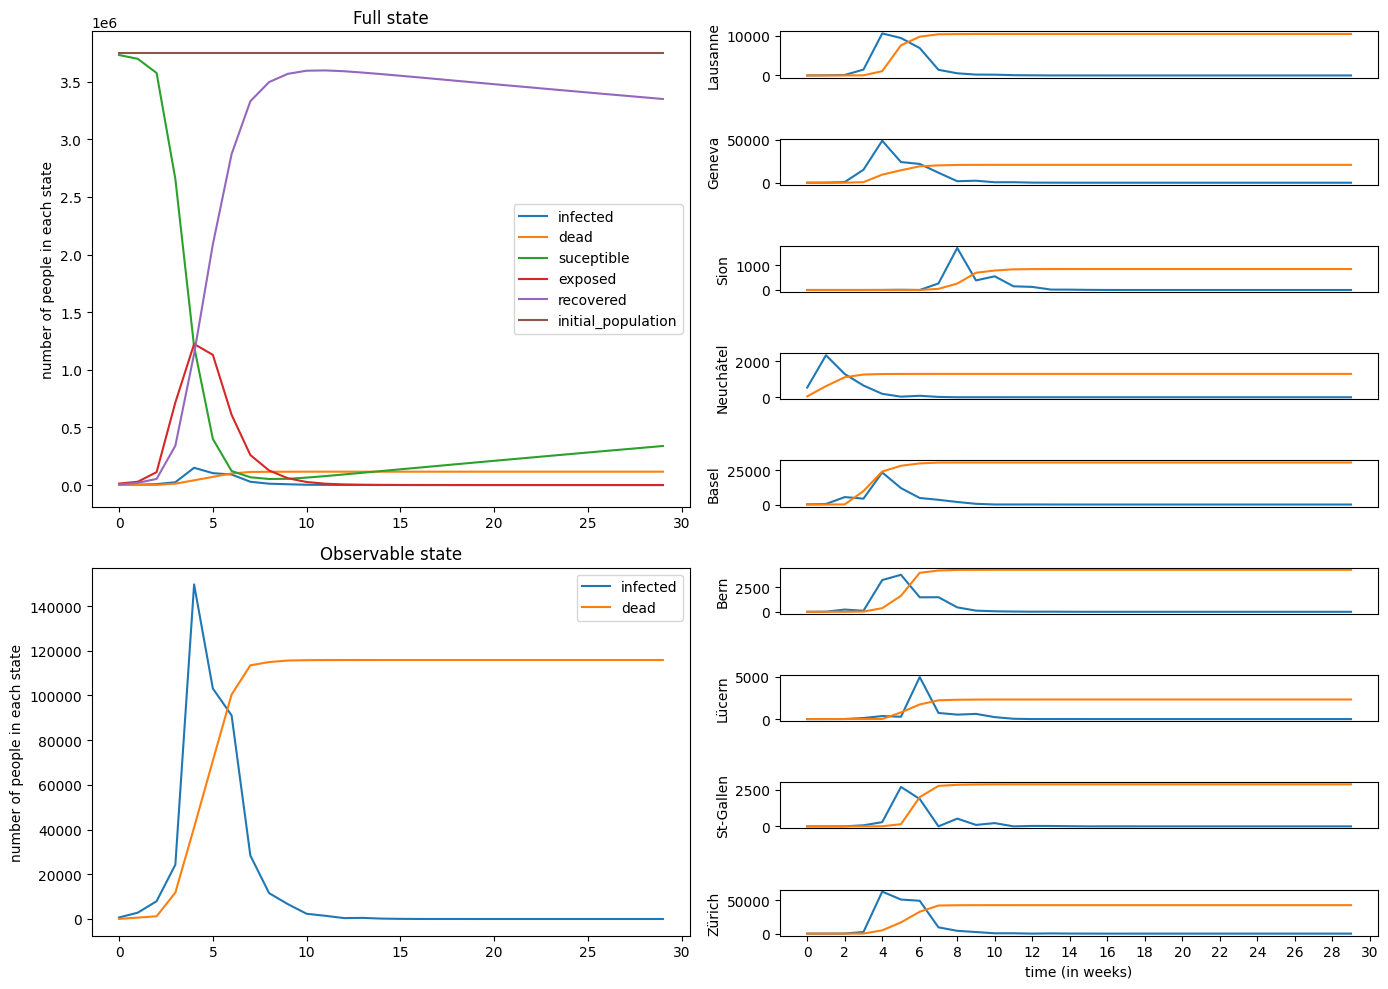

In [351]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

"""Loading the environment"""
env = Env(  dyn, # We pass the dynamical model to the environment 
            action_space=None, # 0 action is taken
            observation_space=None, # No need observation because no DQN
            )

""" Run the simulation """
total, cities, actions = run_evaluation(agent = None, env = env, seed = seed)
    

'''Plot the results'''
plot_evaluation(total, cities)


> **1.a)** When epidemics are unmitigated, the model produces an expected behavior. In the first few weeks, many people is infected, some of whom will die, while the majority will recover. The epidemic will naturally slow down as most of the population is no longer likely to catch the virus again (*left side of the above Figure*). \
The spatial spread of the epidemic is also realistic, as it starts in certain Swiss towns (depending on initialization) and then spread from one town to the next with a lag time (*right side of the above Figure*).

# 2. Pr. Russo's Policy

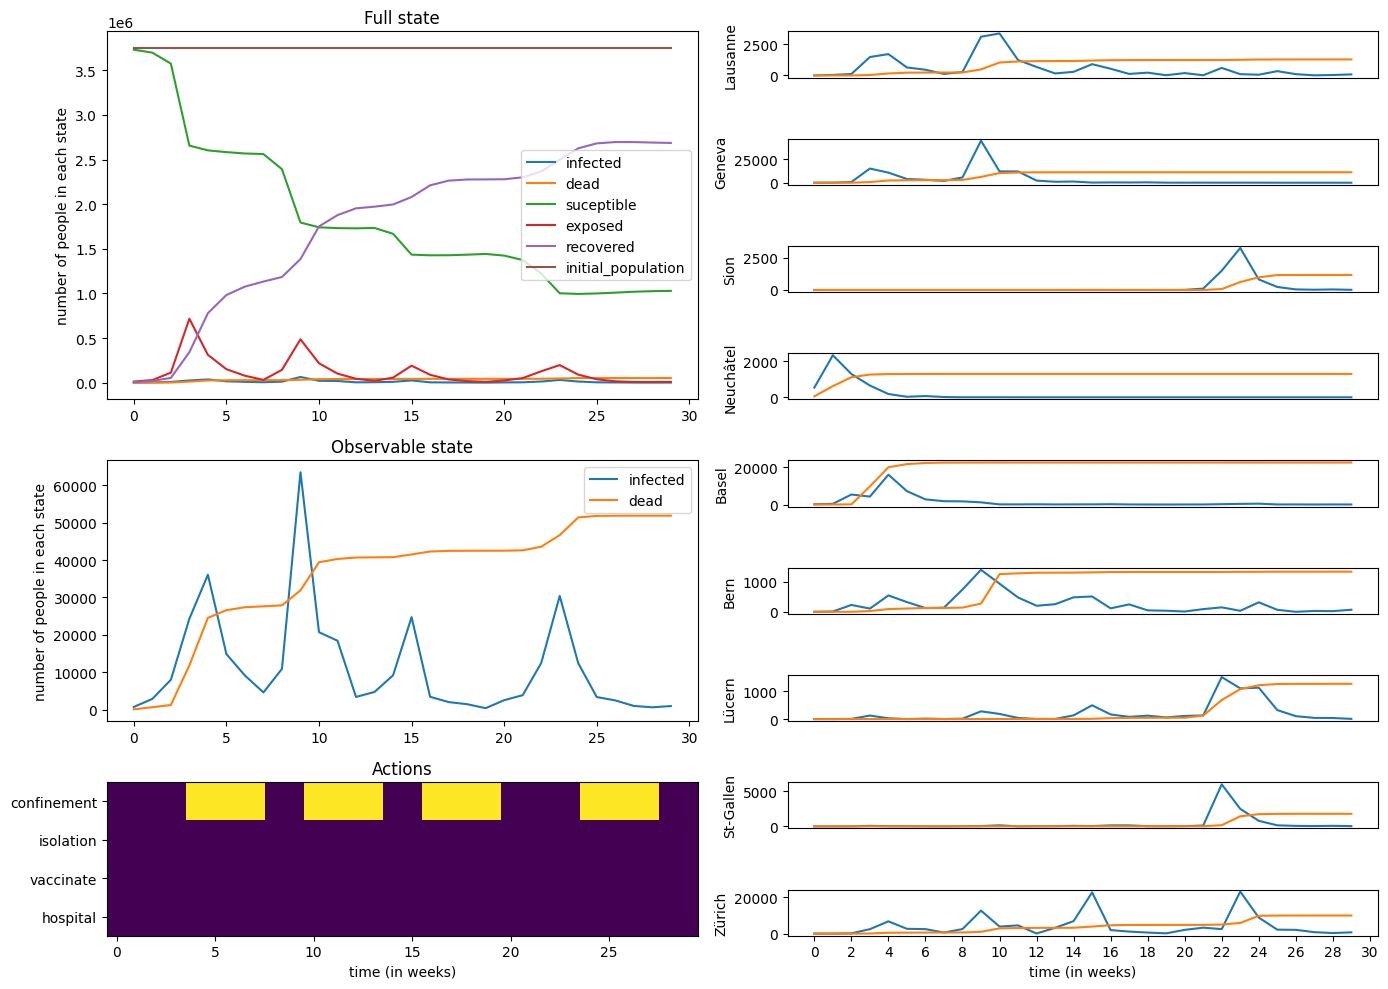

In [425]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

'''Create the actions and the observations spaces'''
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

'''Create the environement'''
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            # Don't put observation preprocessor for this case because RussoAgent needs to know the population of each cities
            )

'''Run the simulation'''
agent_Russo = RussoAgent(env)
total, cities, actions = run_evaluation(agent = agent_Russo)

'''Plot the results'''
plot_evaluation(total, cities, actions)

> **2.a)** With Russo policy, the agent chooses periodically (about every 8 weeks) to confine the entire population for 4 weeks. It performs better than the unmitigated model, dividing the number of deaths by 2 after 30 weeks. However, such measures are impossible to implement in reality, due to their impact on population morale and the fact that they don't seem to contain the epidemic in the long term.

100%|██████████| 50/50 [00:12<00:00,  3.93it/s]


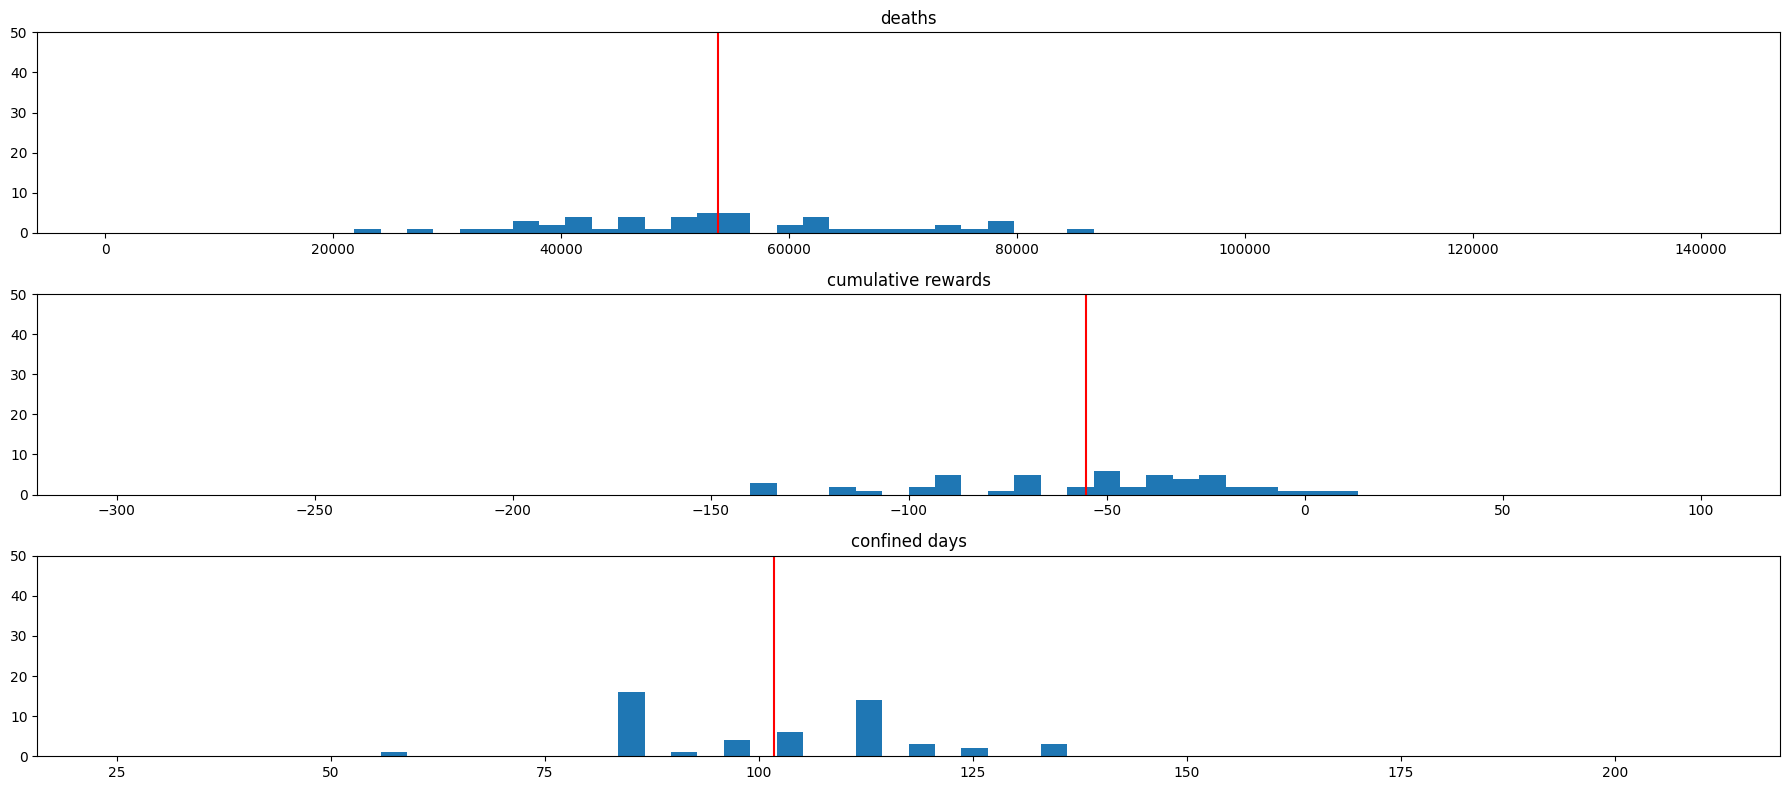

Average death number: 53761.86
Average number of confined days: 101.78
Average cumulative reward: -55.27687454223633


In [359]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)


'''Run several episodes with Russo Agents'''
logs = run_several_evaluations(agent = RussoAgent(env), n_episodes = 50, seed = seed)

'''Evaluate the policy with histograms'''
plot_histograms(logs)

# 3. A DQN approach

## 3.a) Implementing a Deep Q-Learning model

In [400]:
'''Create the environment'''
action_space        =   spaces.Discrete(2)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor,
            )


In [401]:
'''Set parameters of the model'''

N_EPISODES = 500
NUM_EVAL_EPISODES = 20
TARGET_UPDATE_INTERVAL = 5  # Update target network every 5 episodes

BATCH_SIZE = 2048
BUFFER_SIZE = 20000

epsilon_start = 0.7
epsilon_end = 0.2
input_shape = 126  # 2*9*7
action_size = 2  # binary action space
seed = 42  # or any other seed you want to use for reproducibility

In [ ]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

'''Run the simulations'''

# Initialize a list to store logs from each training session
logs = []

# Initialize the best eval trace 
best_eval_trace = -np.inf

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = DQNAgent(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE)

    # Train the agent
    log = agent.train(n_episodes = N_EPISODES, decay_epsilon = False, seed=rd.randint(0,100000))

    # Save the log from this training session
    logs.append(log)
    
    # Save the best agent
    if np.amax(log['eval_trace']) > best_eval_trace:
        best_eval_trace = np.amax(log['eval_trace'])
        best_agent_DQN_no_exp = agent

'''Plot the training and test trace'''
plot_trace(logs)

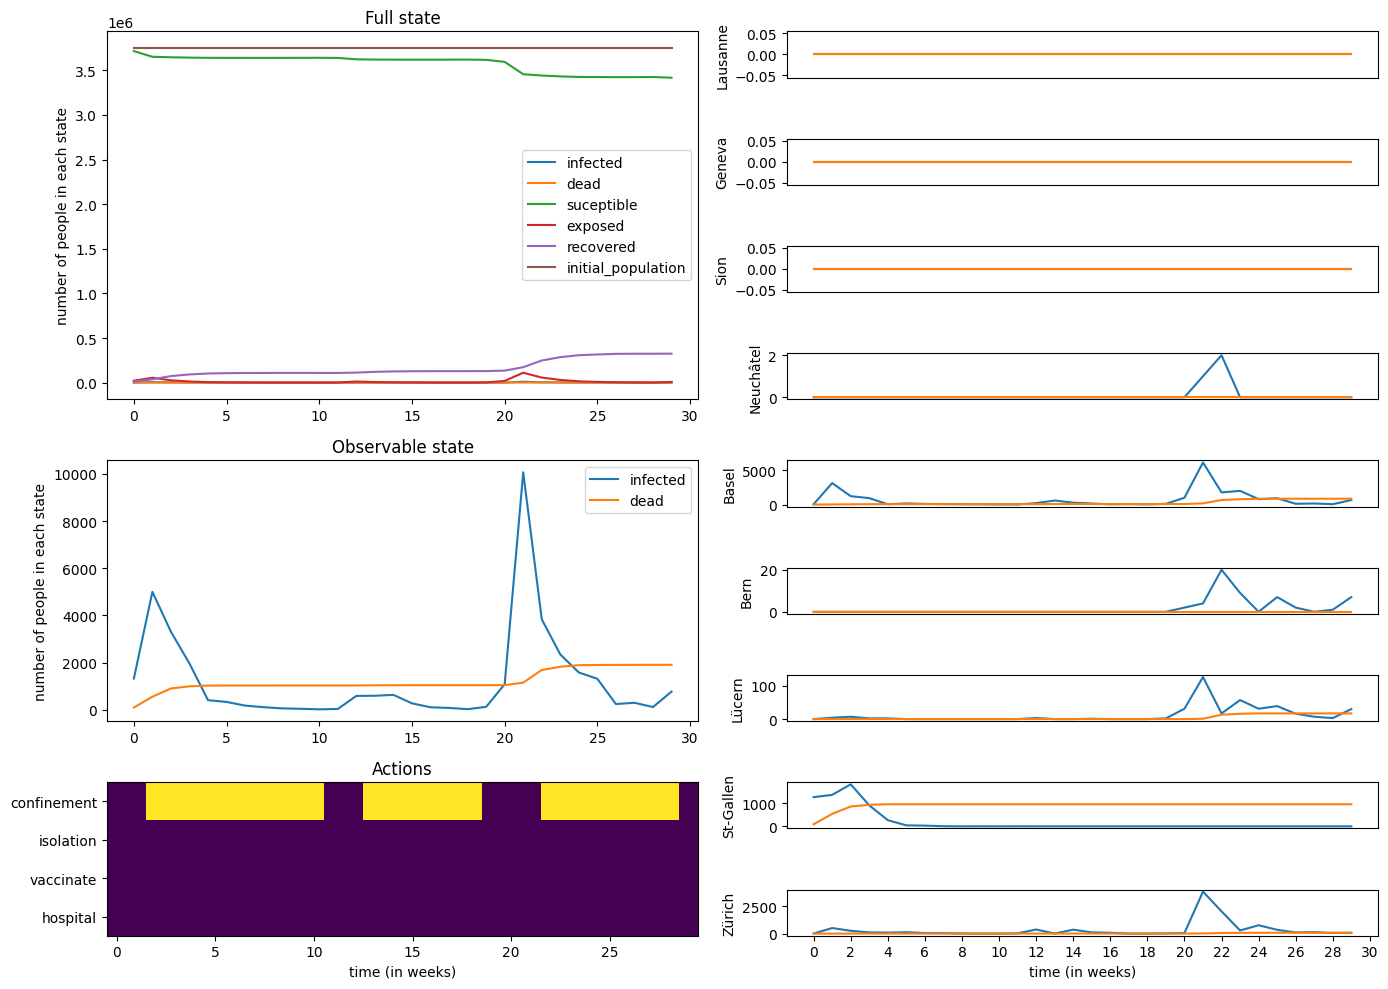

In [ ]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

'''Plot the results over an evaluation with the trained model'''
plot_evaluation(*run_evaluation(best_agent_DQN_no_exp, seed = seed))

>#### **Does your agent learn a meaningful policy?**
>The agent seems to be learning a meaningful policy as the average evaluation reward increases over time. The randomness observed in the training trace is typical due to exploration, whereas evaluation trace uses a deterministic policy, resulting in smoother results. To confirm the meaningfulness of the policy, we should analyze if the agent's decisions in frequently encountered states lead to expected outcomes given your problem context.
>
>#### **Interpret the policy**
>
>Your agent learns a policy that alternates between confinement and relaxation to manage infections. While confinement periods effectively reduce infections, spikes occur during relaxation. The policy reflects real-world strategies, but may need refining to mitigate potential increases in mortality rates.

## 3.b) With decreasing exploration

-------- Training session n° 1  --------


  0%|          | 1/500 [00:13<1:50:39, 13.31s/it]

Episode 1, Avg Eval Reward: -151.11218872070313


 10%|█         | 51/500 [00:53<27:05,  3.62s/it] 

Episode 51, Avg Eval Reward: -140.29121475219728


 20%|██        | 101/500 [01:44<22:36,  3.40s/it]

Episode 101, Avg Eval Reward: 22.690987157821656


 30%|███       | 151/500 [02:29<19:46,  3.40s/it]

Episode 151, Avg Eval Reward: 32.81814427375794


 40%|████      | 201/500 [03:06<13:58,  2.81s/it]

Episode 201, Avg Eval Reward: 37.62072405815125


 50%|█████     | 251/500 [03:42<10:28,  2.53s/it]

Episode 251, Avg Eval Reward: 43.10132274627686


 60%|██████    | 301/500 [04:17<10:13,  3.08s/it]

Episode 301, Avg Eval Reward: 46.99056129455566


 70%|███████   | 351/500 [04:58<06:45,  2.72s/it]

Episode 351, Avg Eval Reward: 43.062310910224916


 80%|████████  | 401/500 [05:34<04:46,  2.90s/it]

Episode 401, Avg Eval Reward: 43.046034812927246


 90%|█████████ | 451/500 [06:14<02:21,  2.88s/it]

Episode 451, Avg Eval Reward: 37.405092000961304


100%|██████████| 500/500 [06:47<00:00,  1.23it/s]


-------- Training session n° 2  --------


  0%|          | 1/500 [00:08<1:13:32,  8.84s/it]

Episode 1, Avg Eval Reward: 23.03570475578308


 10%|█         | 51/500 [00:35<19:15,  2.57s/it] 

Episode 51, Avg Eval Reward: 23.18477783203125


 20%|██        | 101/500 [01:10<17:38,  2.65s/it]

Episode 101, Avg Eval Reward: 37.135134601593016


 30%|███       | 151/500 [01:46<15:49,  2.72s/it]

Episode 151, Avg Eval Reward: 38.26975650787354


 40%|████      | 201/500 [02:22<13:38,  2.74s/it]

Episode 201, Avg Eval Reward: 33.764401054382326


 50%|█████     | 251/500 [02:59<11:37,  2.80s/it]

Episode 251, Avg Eval Reward: 43.51332550048828


 60%|██████    | 301/500 [03:36<09:54,  2.99s/it]

Episode 301, Avg Eval Reward: 39.78112258911133


 70%|███████   | 351/500 [04:11<06:03,  2.44s/it]

Episode 351, Avg Eval Reward: 38.72199649810791


 80%|████████  | 401/500 [04:45<04:11,  2.54s/it]

Episode 401, Avg Eval Reward: 48.251340579986575


 90%|█████████ | 451/500 [05:21<01:56,  2.38s/it]

Episode 451, Avg Eval Reward: 45.946303081512454


100%|██████████| 500/500 [06:09<00:00,  1.35it/s]


-------- Training session n° 3  --------


  0%|          | 1/500 [00:10<1:23:12, 10.00s/it]

Episode 1, Avg Eval Reward: -150.52283401489257


 10%|█         | 51/500 [00:43<23:45,  3.18s/it] 

Episode 51, Avg Eval Reward: -168.3479965209961


 20%|██        | 101/500 [01:28<25:06,  3.78s/it]

Episode 101, Avg Eval Reward: 27.954337310791015


 30%|███       | 151/500 [02:19<20:12,  3.47s/it]

Episode 151, Avg Eval Reward: 27.38100709915161


 40%|████      | 201/500 [03:06<15:36,  3.13s/it]

Episode 201, Avg Eval Reward: 29.379283946752548


 50%|█████     | 251/500 [03:57<13:15,  3.20s/it]

Episode 251, Avg Eval Reward: 27.781828117370605


 60%|██████    | 301/500 [04:44<11:09,  3.36s/it]

Episode 301, Avg Eval Reward: 29.662191104888915


 70%|███████   | 351/500 [05:29<07:22,  2.97s/it]

Episode 351, Avg Eval Reward: 31.80251235961914


 80%|████████  | 401/500 [05:57<03:22,  2.05s/it]

Episode 401, Avg Eval Reward: 36.316286182403566


 90%|█████████ | 451/500 [06:24<01:37,  2.00s/it]

Episode 451, Avg Eval Reward: 30.996689748764037


100%|██████████| 500/500 [06:46<00:00,  1.23it/s]


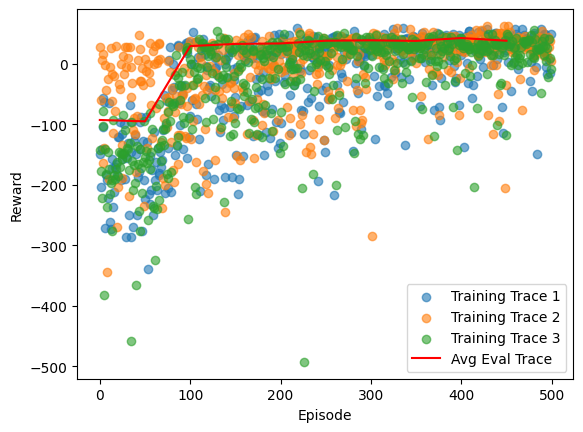

In [394]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

'''Run the simulations'''

# Initialize a list to store logs from each training session
logs = []

# Initalize the best eval trace
best_eval_trace = -np.inf

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = DQNAgent(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE)

    # Train the agent
    log = agent.train(n_episodes = 500, decay_epsilon = True, seed = rd.randint(0,10000))

    # Save the log from this training session
    logs.append(log)

    # Save the best agent
    if np.amax(log['eval_trace']) > best_eval_trace:
        best_eval_trace = np.amax(log['eval_trace'])
        best_agent_DQN_exp = agent

'''Plot the training and test trace'''
plot_trace(logs)

>#### **Compare and discuss the results between questions 3.a) and 3.b). Which policy gets the best results and why?**
>
>In both cases, the evaluation trace shows similar trends indicating effective learning. However, the training trace in the case of Deep Q-Learning with epsilon decay is less random, suggesting improved learning over time compared to the fixed epsilon approach. This indicates that the policy from epsilon decay approach provides better results. The reason for this could be that the epsilon decay method balances exploration and exploitation more effectively, allowing the agent to explore the environment initially and then increasingly exploit learned knowledge, leading to a more consistent learning process.

## 3.c) Evaluate the best performing policy against Pr. Russo’s policy

100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


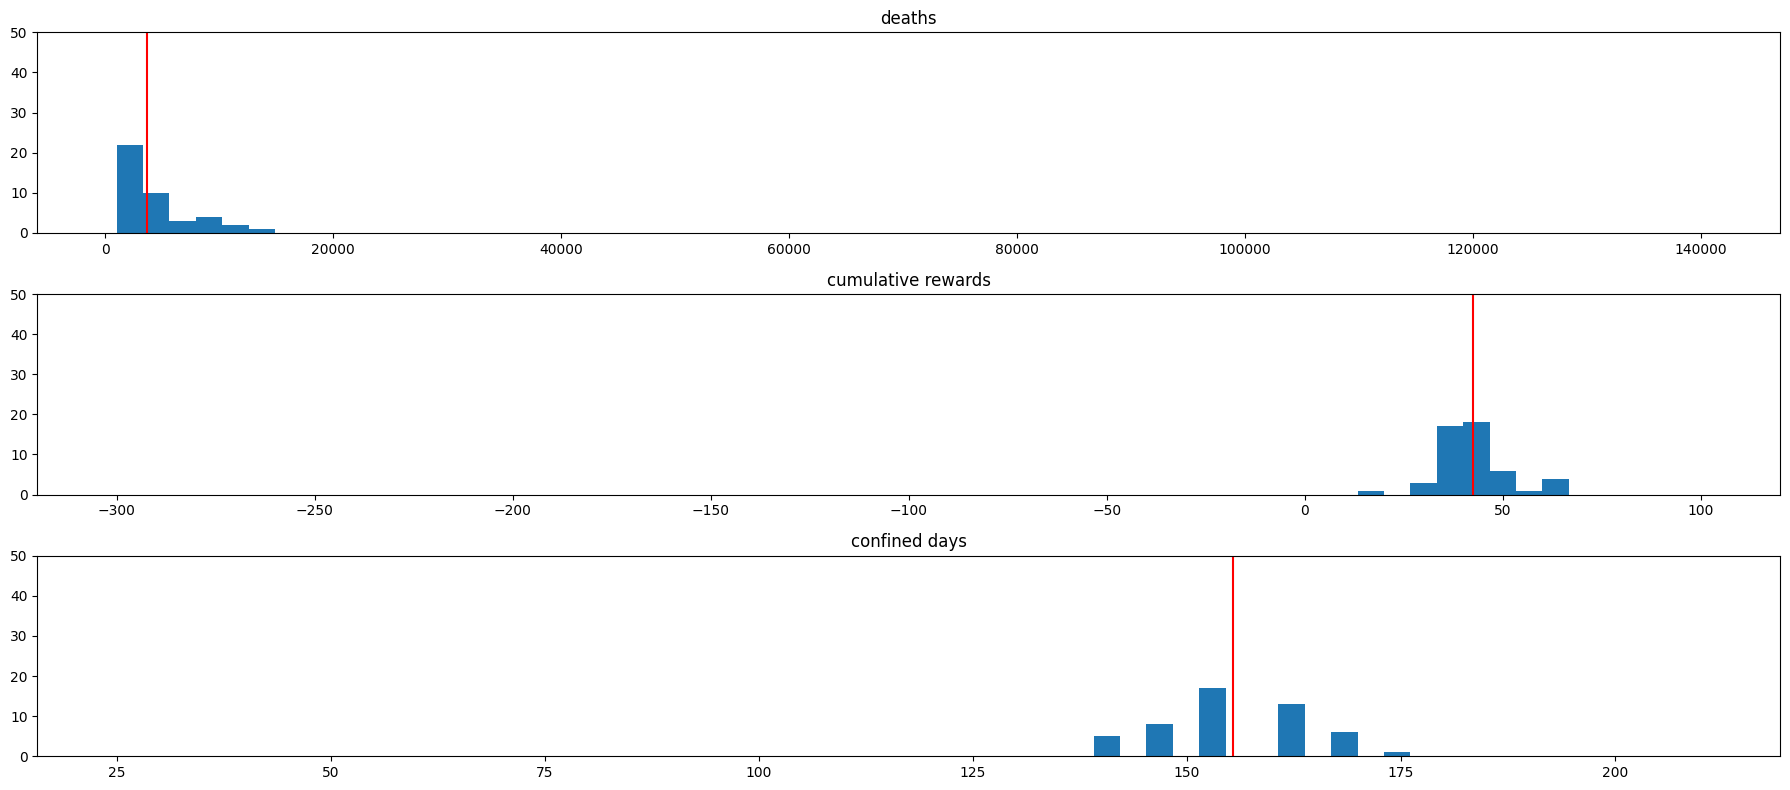

Average death number: 3704.52
Average number of confined days: 155.4
Average cumulative reward: 42.5499153137207


In [395]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

'''Plot histograms'''
plot_histograms(run_several_evaluations(best_agent_DQN_exp, seed = seed))

>#### **Did the reinforcement learning policy outperform Pr. Russo’s, if so in what sense?**
>
>Yes, the reinforcement learning policy using Deep Q-Learning outperformed Professor Russo's policy in several key aspects. It significantly reduced the average number of total deaths, a critical health outcome, indicating a more effective control of the virus spread. Furthermore, it also achieved a higher average cumulative reward, suggesting a more efficient balance between confinement days and the resulting health and societal impacts.

# 4. Dealing with a more complex action space

## 4.1 Toggle-action-space multi-action agent

### 4.1. a) (Theory) Action space design

> #### **Discuss, the impact on network architecture and on training.**
>
>The toggle-action space adds flexibility to decision-making, especially in complex environments with long-term action effects. It requires modifications to the network architecture to accommodate the extended observation space and more possible actions, thereby potentially slowing down training. However, it can yield more nuanced policies and encourage strategic long-term behavior.

### 4.1. b) Toggle-action-space multi-action policy training

In [407]:
'''Create the environement'''
action_space        =   spaces.Discrete(5)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_toggle,
            observation_preprocessor=observation_preprocessor_toggle,
            )

In [408]:
'''Set parameters of the model'''
input_shape = 3*9*7 + 4  # 189 + 4
action_size = 5 

-------- Training session n° 1  --------


  0%|          | 1/500 [00:05<48:33,  5.84s/it]

Episode 1, Avg Eval Reward: -132.016854095459 Epsilon : 0.7


 10%|█         | 51/500 [00:25<15:30,  2.07s/it]

Episode 51, Avg Eval Reward: -116.92476310729981 Epsilon : 0.63


 20%|██        | 101/500 [00:52<14:40,  2.21s/it]

Episode 101, Avg Eval Reward: -0.557513427734375 Epsilon : 0.56


 30%|███       | 151/500 [01:22<12:30,  2.15s/it]

Episode 151, Avg Eval Reward: 24.782665157318114 Epsilon : 0.48999999999999994


 40%|████      | 201/500 [01:52<10:06,  2.03s/it]

Episode 201, Avg Eval Reward: 13.226211619377136 Epsilon : 0.42


 50%|█████     | 251/500 [02:20<08:24,  2.02s/it]

Episode 251, Avg Eval Reward: 19.56998593211174 Epsilon : 0.35


 60%|██████    | 301/500 [02:49<06:45,  2.04s/it]

Episode 301, Avg Eval Reward: 13.33814035654068 Epsilon : 0.28


 70%|███████   | 351/500 [03:18<05:01,  2.02s/it]

Episode 351, Avg Eval Reward: 26.83156566619873 Epsilon : 0.21


 80%|████████  | 401/500 [03:47<03:20,  2.02s/it]

Episode 401, Avg Eval Reward: 26.83498685359955 Epsilon : 0.2


 90%|█████████ | 451/500 [04:16<01:40,  2.05s/it]

Episode 451, Avg Eval Reward: 19.633825731277465 Epsilon : 0.2


100%|██████████| 500/500 [04:40<00:00,  1.78it/s]


-------- Training session n° 2  --------


  0%|          | 1/500 [00:05<46:39,  5.61s/it]

Episode 1, Avg Eval Reward: -124.7602912902832 Epsilon : 0.7


 10%|█         | 51/500 [00:24<13:46,  1.84s/it]

Episode 51, Avg Eval Reward: -123.27666397094727 Epsilon : 0.63


 20%|██        | 101/500 [00:48<13:52,  2.09s/it]

Episode 101, Avg Eval Reward: 1.2118722915649414 Epsilon : 0.56


 30%|███       | 151/500 [01:20<13:28,  2.32s/it]

Episode 151, Avg Eval Reward: 23.566341400146484 Epsilon : 0.48999999999999994


 40%|████      | 201/500 [01:50<10:48,  2.17s/it]

Episode 201, Avg Eval Reward: 7.239839661121368 Epsilon : 0.42


 50%|█████     | 251/500 [02:21<08:55,  2.15s/it]

Episode 251, Avg Eval Reward: 28.845173087716102 Epsilon : 0.35


 60%|██████    | 301/500 [02:51<07:07,  2.15s/it]

Episode 301, Avg Eval Reward: 23.42304685115814 Epsilon : 0.28


 70%|███████   | 351/500 [03:21<05:23,  2.17s/it]

Episode 351, Avg Eval Reward: 29.852239155769347 Epsilon : 0.21


 80%|████████  | 401/500 [03:52<03:30,  2.12s/it]

Episode 401, Avg Eval Reward: 36.10256862640381 Epsilon : 0.2


 90%|█████████ | 451/500 [04:22<01:42,  2.08s/it]

Episode 451, Avg Eval Reward: 37.03261694908142 Epsilon : 0.2


100%|██████████| 500/500 [04:46<00:00,  1.74it/s]


-------- Training session n° 3  --------


  0%|          | 1/500 [00:05<48:07,  5.79s/it]

Episode 1, Avg Eval Reward: -86.43703994750976 Epsilon : 0.7


 10%|█         | 51/500 [00:24<13:41,  1.83s/it]

Episode 51, Avg Eval Reward: -69.43536033630372 Epsilon : 0.63


 20%|██        | 101/500 [00:49<13:34,  2.04s/it]

Episode 101, Avg Eval Reward: -35.1957124888897 Epsilon : 0.56


 30%|███       | 151/500 [01:17<11:46,  2.02s/it]

Episode 151, Avg Eval Reward: 18.530595779418945 Epsilon : 0.48999999999999994


 40%|████      | 201/500 [01:47<10:39,  2.14s/it]

Episode 201, Avg Eval Reward: 16.450228083133698 Epsilon : 0.42


 50%|█████     | 251/500 [02:16<08:39,  2.08s/it]

Episode 251, Avg Eval Reward: 32.921129608154295 Epsilon : 0.35


 60%|██████    | 301/500 [02:46<06:48,  2.05s/it]

Episode 301, Avg Eval Reward: 31.061240196228027 Epsilon : 0.28


 70%|███████   | 351/500 [03:15<05:04,  2.04s/it]

Episode 351, Avg Eval Reward: 21.222153466939925 Epsilon : 0.21


 80%|████████  | 401/500 [03:47<03:27,  2.09s/it]

Episode 401, Avg Eval Reward: 29.003652381896973 Epsilon : 0.2


 90%|█████████ | 451/500 [04:18<02:01,  2.47s/it]

Episode 451, Avg Eval Reward: 32.87603791952133 Epsilon : 0.2


100%|██████████| 500/500 [04:41<00:00,  1.78it/s]


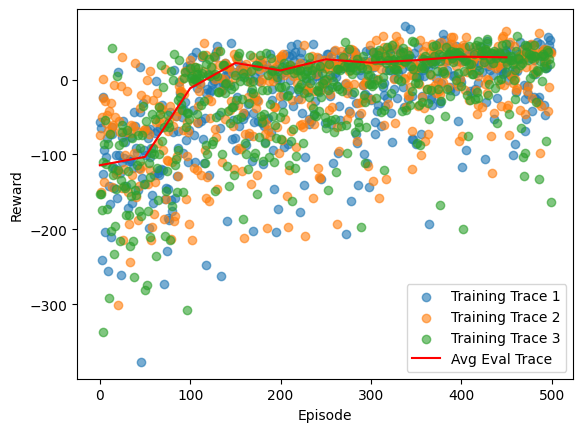

In [409]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

'''Run the simulation'''
# Initialize a list to store logs from each training session
logs = []

# Initialize best eval trace
best_eval_trace = -np.inf

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = DQNAgent_TOGGLE(input_shape, action_size, env, epsilon = epsilon_start, memory_size=BUFFER_SIZE, lr = 1e-3)

    # Train the agent
    log = agent.train(n_episodes = 500, decay_epsilon = True, seed = rd.randint(0, 10000))

    # Save the log from this training session
    logs.append(log)

    # Save the best agent
    if np.amax(log['eval_trace']) > best_eval_trace:
        best_eval_trace = np.amax(log['eval_trace'])
        best_agent_toggle = agent

'''Plot the training and the test traces'''
plot_trace(logs)

>#### **Is the agent properly learning?**
>
>Given that the evaluation and training traces both start at a low value and gradually increase towards a positive reward, it does suggest that the agent is learning effectively. To better understand the policy's behavior, running three episodes using the learned policy (π∗) would provide valuable insights into its decision-making process across different situations. This will help in identifying patterns in the actions taken, their corresponding states, and how these decisions lead to the observed rewards.

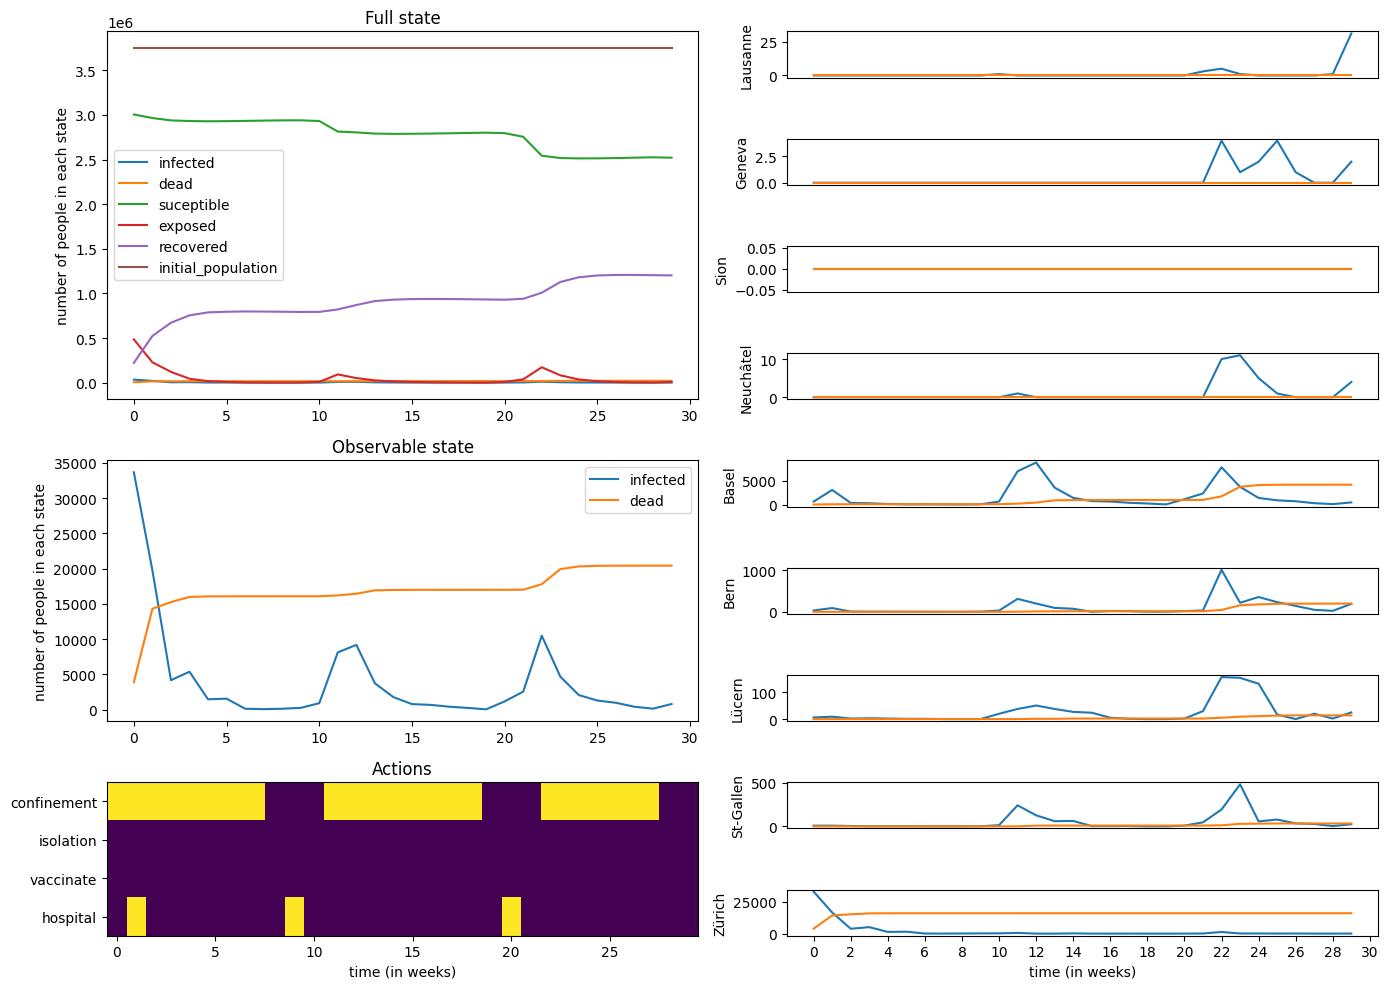

In [411]:
'''Plot the result of 1 evaluation episode'''
plot_evaluation(*run_evaluation(best_agent_toggle, toggle = True))

>#### **Interpret the policy.**
>
>The learned policy appears to heavily prioritize confinement and isolation measures to effectively reduce the number of susceptible and infected individuals over time. As the episode progresses, it starts introducing vaccinations and hospital provisions, indicating a shift towards recovery and prevention. The minimal time without confinement suggests a conservative strategy focused on containment to control the spread of the virus.

### 4.1. c) Toggle-action-space multi-action policy evaluation

100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


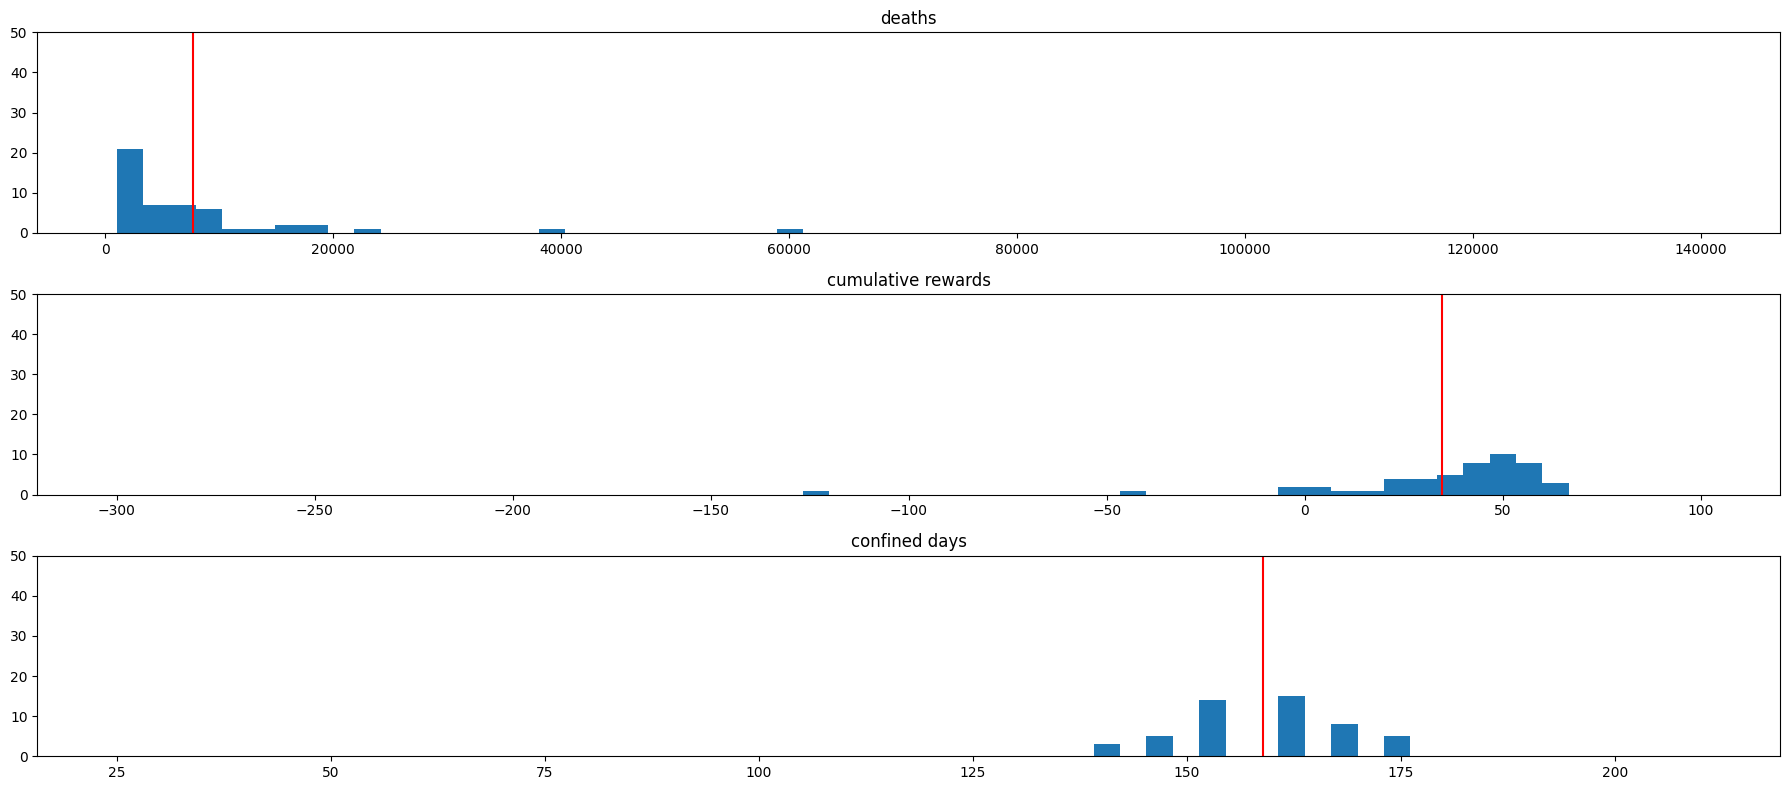

Average death number: 7731.68
Average number of confined days: 158.9
Average cumulative reward: 34.677799224853516


In [412]:
plot_histograms(run_several_evaluations(best_agent_toggle, n_episodes = 50, toggle = True))

>#### **How does the policy perform compared to the binary action policy evaluated in question 3.c?**
>
>Compared to the binary action policy (DQN), the toggle-action policy results in a higher average death number and fewer confinement and isolation days. However, the cumulative reward of the toggle-action policy is also higher, suggesting a more balanced approach in managing the trade-off between public health and social-economic factors. Despite the higher mortality rate, the policy achieves a positive reward while reducing the societal impact of confinement and isolation, indicating an overall better performance.

### 4.1. d) (Theory) question about toggled-action-space policy, what assumption does it make?

>#### **What assumptions does the use of such a technique make on the action space? Could you think of an action space for which toggling the toggle actions would not be suitable?**
>
>The use of a toggle-action-space policy assumes that the actions are binary and can be toggled between two states (e.g., on/off, true/false). This means that the impact of an action doesn't depend on its past frequency or sequence but simply on its current state.
>
>However, toggle-actions might not be suitable for action spaces where actions have more than two states or the effect of actions is cumulative or dependent on sequence. For instance, in a game where the actions represent levels of engagement (e.g., low, medium, high), toggling wouldn't make sense. Similarly, in a navigation problem, where the action sequence matters (e.g., "go north" then "go east" leads to a different location than "go east" then "go north"), toggling would not be applicable.

## 4.2 Factorized Q-values, multi-action agent

### 4.2. a)  Multi-action factorized Q-values policy training

In [413]:
'''Create the environment'''
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor_FactorizedQ,
            observation_preprocessor=observation_preprocessor,
            )

-------- Training session n° 1  --------


  0%|          | 1/500 [00:05<46:23,  5.58s/it]

Episode 1, Avg Eval Reward: 32.47043228149414


 10%|█         | 51/500 [00:24<14:06,  1.88s/it]

Episode 51, Avg Eval Reward: 45.269228076934816


 20%|██        | 101/500 [00:49<13:20,  2.01s/it]

Episode 101, Avg Eval Reward: -4.028886812925339


 30%|███       | 151/500 [01:17<11:37,  2.00s/it]

Episode 151, Avg Eval Reward: 6.612315082550049


 40%|████      | 201/500 [01:44<10:03,  2.02s/it]

Episode 201, Avg Eval Reward: 2.6687230229377747


 50%|█████     | 251/500 [02:12<08:21,  2.01s/it]

Episode 251, Avg Eval Reward: 13.361332991719246


 60%|██████    | 301/500 [02:40<06:43,  2.03s/it]

Episode 301, Avg Eval Reward: 21.262498128414155


 70%|███████   | 351/500 [03:08<04:58,  2.01s/it]

Episode 351, Avg Eval Reward: 28.939910793304442


 80%|████████  | 401/500 [03:36<03:20,  2.02s/it]

Episode 401, Avg Eval Reward: 28.052817606925963


 90%|█████████ | 451/500 [04:05<01:38,  2.01s/it]

Episode 451, Avg Eval Reward: 26.46879086494446


100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


-------- Training session n° 2  --------


  0%|          | 1/500 [00:05<45:40,  5.49s/it]

Episode 1, Avg Eval Reward: -6.342867922782898


 10%|█         | 51/500 [00:23<13:29,  1.80s/it]

Episode 51, Avg Eval Reward: -6.220489358901977


 20%|██        | 101/500 [00:47<13:18,  2.00s/it]

Episode 101, Avg Eval Reward: 22.265982246398927


 30%|███       | 151/500 [01:14<11:39,  2.00s/it]

Episode 151, Avg Eval Reward: 21.047460794448853


 40%|████      | 201/500 [01:42<10:03,  2.02s/it]

Episode 201, Avg Eval Reward: 25.470543479919435


 50%|█████     | 251/500 [02:10<08:42,  2.10s/it]

Episode 251, Avg Eval Reward: 28.28799409866333


 60%|██████    | 301/500 [02:39<06:42,  2.02s/it]

Episode 301, Avg Eval Reward: 28.98518900871277


 70%|███████   | 351/500 [03:07<05:01,  2.02s/it]

Episode 351, Avg Eval Reward: 32.0692476272583


 80%|████████  | 401/500 [03:35<03:21,  2.03s/it]

Episode 401, Avg Eval Reward: 33.98948669433594


 90%|█████████ | 451/500 [04:03<01:38,  2.02s/it]

Episode 451, Avg Eval Reward: 38.088255882263184


100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


-------- Training session n° 3  --------


  0%|          | 1/500 [00:05<45:21,  5.45s/it]

Episode 1, Avg Eval Reward: -138.2674575805664


 10%|█         | 51/500 [00:23<13:37,  1.82s/it]

Episode 51, Avg Eval Reward: -164.9180892944336


 20%|██        | 101/500 [00:47<13:16,  2.00s/it]

Episode 101, Avg Eval Reward: 14.52389681339264


 30%|███       | 151/500 [01:14<11:37,  2.00s/it]

Episode 151, Avg Eval Reward: 9.340120136737823


 40%|████      | 201/500 [01:42<10:11,  2.05s/it]

Episode 201, Avg Eval Reward: 14.70920307636261


 50%|█████     | 251/500 [02:10<08:16,  1.99s/it]

Episode 251, Avg Eval Reward: 15.916949391365051


 60%|██████    | 301/500 [02:38<06:40,  2.01s/it]

Episode 301, Avg Eval Reward: 15.120455336570739


 70%|███████   | 351/500 [03:06<05:00,  2.02s/it]

Episode 351, Avg Eval Reward: 25.22814548611641


 80%|████████  | 401/500 [03:34<03:26,  2.09s/it]

Episode 401, Avg Eval Reward: 27.227318620681764


 90%|█████████ | 451/500 [04:02<01:38,  2.01s/it]

Episode 451, Avg Eval Reward: 31.490204524993896


100%|██████████| 500/500 [04:25<00:00,  1.89it/s]


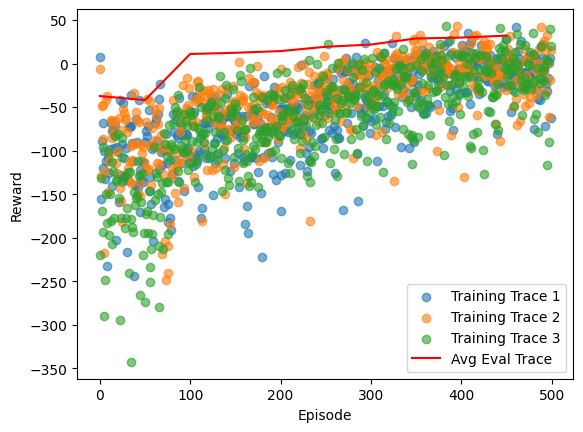

In [415]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.use_deterministic_algorithms(True)

'''Run the simulations'''
# Initialize a list to store logs from each training session
logs = []

# Initialize best eval trace
best_eval_trace = -np.inf

# Number of training sessions
num_training_sessions = 3

# Train the agent multiple times
for i in range(num_training_sessions):
    print("-------- Training session n°", i + 1, " --------")
    # Initialize a new agent for each session
    agent = FactorizedQ(env = env, learning_rate= 1e-3)
    
    # Train the agent
    log = agent.train(n_episodes = 500, decay_epsilon = True, seed = rd.randint(0,10000))

    # Save the log from this training session
    logs.append(log)

    # Save the best agent
    if np.amax(log['eval_trace']) > best_eval_trace:
        best_eval_trace = np.amax(log['eval_trace'])
        best_agent_factorized = agent
    

'''Plot the training and test trace'''
plot_trace(logs)

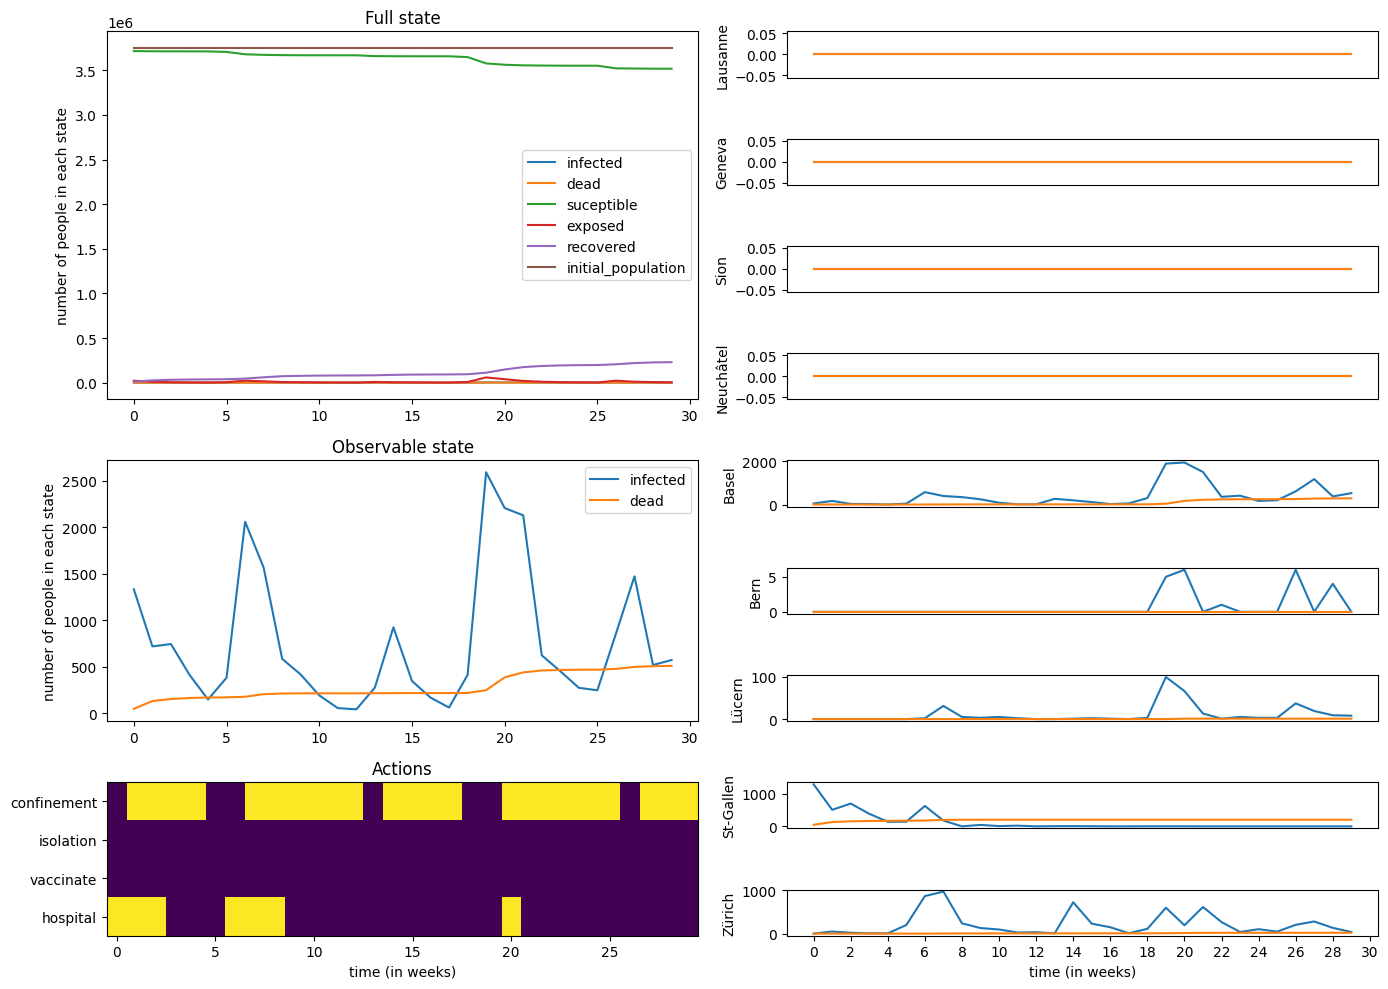

In [416]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

'''Plot the results over an evaluation with the trained model'''
plot_evaluation(*run_evaluation(best_agent_factorized, seed = seed))

### 4.2. b)  Multi-action factorized Q-values policy evaluation

100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


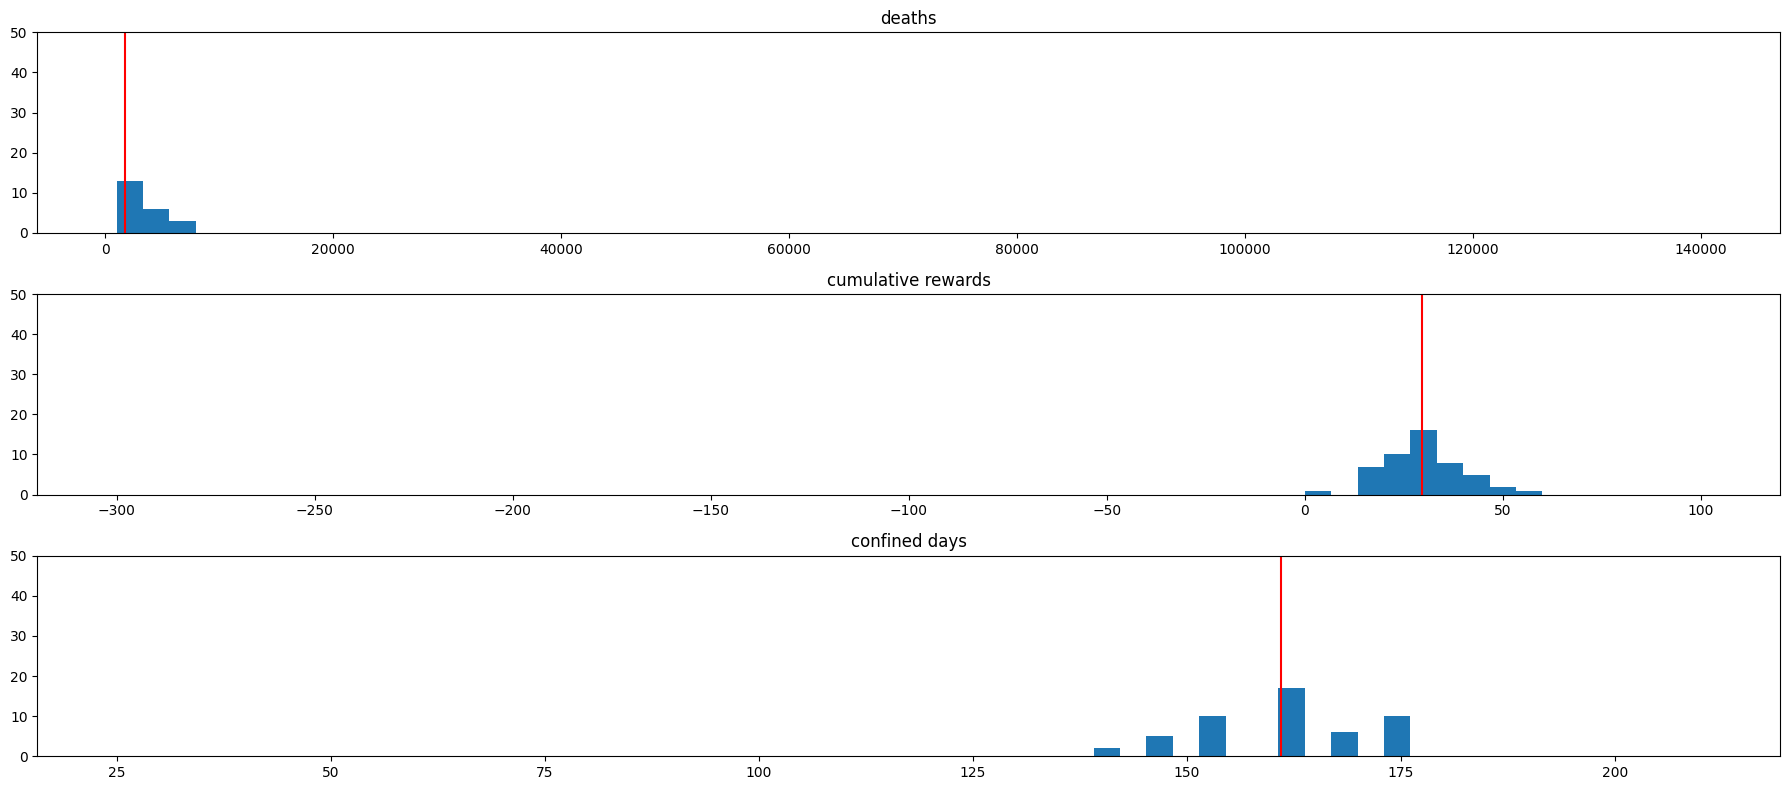

Average death number: 1744.36
Average number of confined days: 161.0
Average cumulative reward: 29.655393600463867


In [418]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

'''Plot histograms'''
plot_histograms(run_several_evaluations(best_agent_factorized, seed = seed))

### 4.2. c) (Theory) Factorized-Q-values, what assumption does it make?

> #### **What assumptions does the use of such a technique make on the action space? Think of an action space for which factorizing Q-values would not be suitable**
> Factorized-Q-values make the assumptions that each action of the action space is independant. In such a case, the choice of factorized Q value seems to be appropriate, as it allows the agent to explore all possible combinations of actions to determine the best one. 
>
> On the other hand, in some action space cases where actions are not independent, this would not have been appropriate. Let's imagine we have an action space made up of the actions "go south", "go north", "go east" and "go west". In this case, the factorized Q-values multi action agent is not suitable, as the actions "go south" and "go north" or "go east" and "go west" cannot be taken simultaneously.

### 5. a) (Result analysis) Comparing the training behaviors

### 5. b) (Result analysis) Comparing policies

In [426]:
'''For reproducibility'''
seed = 0
rd.seed(seed)
np.random.seed(seed)

'''Run several episodes with all the policies'''
logs_Russo = run_several_evaluations(agent = agent_Russo, n_episodes = 50, seed = seed)
logs_DQN = run_several_evaluations(best_agent_DQN_exp, n_episodes = 50, toggle = False)
logs_toggle = run_several_evaluations(best_agent_toggle, n_episodes = 50, toggle = True)
logs_facto = run_several_evaluations(best_agent_factorized, n_episodes = 50, toggle = False)

100%|██████████| 50/50 [00:12<00:00,  3.88it/s]


In [429]:
logs_DQN.keys()

dict_keys(['Episode', 'conf_days', 'R_cumul', 'N_deaths', 'isol_days', 'vacc_days', 'hosp_days'])

### 5. c) (Interpretability) Q-values

### 5. d) (Theory), Is cumulative reward an increasing function of the number of actions?